In [1]:
# Import necessary libraries
import time
from math import sqrt
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

from xgboost import XGBRegressor

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import Binarizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set(font='serif', style='ticks')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif']=['Arial Unicode MS']

plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam, Nadam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D

In [2]:
# Load data
data = pd.read_csv('./Vm.csv')
X = data[['PSI', 'DELTA']]
Y = data[['n', 'k']]

In [3]:
# Standardize the data.
transfer1 = StandardScaler()
X = transfer1.fit_transform(X)

transfer2 = StandardScaler()
Y = transfer2.fit_transform(Y)

In [4]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = X.shape[0] // samples_per_slice
feature_slices_X = X[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x = np.stack(feature_slices_X, axis=0)
samples_per_slice = 701
n_samples = Y.shape[0] // samples_per_slice
feature_slices_Y = Y[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y = np.stack(feature_slices_Y, axis=0)

(606, 701, 2)


In [6]:
# Split the data into training and testing sets.
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=24,shuffle=True)

In [ ]:
def create_model(trial):
    # Selection optimizer
    optimizer_options = {'Adam': Adam, 'Nadam': Nadam, 'Adamax': Adamax}
    chosen_optimizer = optimizer_options[trial.suggest_categorical('optimizer', ['Adam', 'Nadam', 'Adamax'])]

    # Selective activation function
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu', 'leaky_relu', 'linear'])

    # Set L2 regularization intensity
    l2_reg = l2(trial.suggest_float('l2_reg', 1e-100, 1e-1, log=True))

    # Building model
    input_seq = Input(shape=(701, 2))
    encoder = Conv1D(32, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(input_seq)
    encoder = MaxPooling1D(2, padding='same')(encoder)
    encoder = Conv1D(64, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(encoder)
    encoder = MaxPooling1D(2, padding='same')(encoder)
    encoded = Conv1D(128, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(encoder)
    encoded = MaxPooling1D(2, padding='same')(encoded)

    decoder = Conv1D(128, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(encoded)
    decoder = UpSampling1D(2)(decoder)
    decoder = Conv1D(64, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(decoder)
    decoder = UpSampling1D(2)(decoder)
    decoder = Conv1D(32, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(decoder)
    decoder = UpSampling1D(2)(decoder)
    decoder = Cropping1D((1, 2))(decoder)
    output_seq = Conv1D(2, 3, activation=activation, padding='same', kernel_regularizer=l2_reg)(decoder)

    model = Model(inputs=input_seq, outputs=output_seq)

    # Compilation model
    model.compile(optimizer=chosen_optimizer(trial.suggest_float('lr', 1e-10, 1e-2, log=True)),
                  loss='mean_squared_error')

    return model

def objective(trial):
    # create models
    model = create_model(trial)

    # EarlyStopping parameter
    patience = trial.suggest_int('patience', 5, 70)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, min_delta=0.00001)

    # Training model
    history = model.fit(x_train, y_train,
                        epochs=300,
                        batch_size=trial.suggest_categorical('batch_size', [8,16,32, 64, 128, 256, 512]),
                        validation_split=trial.suggest_float('validation_split', 0.1, 0.7),
                        callbacks=[early_stopping],
                        verbose=0)

    return min(history.history['val_loss'])

# Create a study object
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=37)

# Print optimum parameter
print('Best trial:', study.best_trial.params)

In [ ]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)

# Prints all parameters and values
print("All params and values:")
for trial in study.trials:
    print("Trial #{}: params={}, value={}".format(trial.number, trial.params, trial.value))

In [195]:
# Build the model according to the best parameters
input_seq = Input(shape=(701, 2))

l2_reg = l2(9.391847488984065e-63)

# Encoder
encoder = Conv1D(filters=32, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(input_seq)
encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)  

encoder = Conv1D(filters=64, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(encoder)
encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)  

encoded = Conv1D(filters=128, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(encoder)
encoded = MaxPooling1D(pool_size=2, padding='same')(encoded) 

# Decoder
decoder = Conv1D(filters=128, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(encoded)
decoder = UpSampling1D(size=2)(decoder) 

decoder = Conv1D(filters=64, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(decoder)
decoder = UpSampling1D(size=2)(decoder) 

decoder = Conv1D(filters=32, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(decoder)
decoder = UpSampling1D(size=2)(decoder) 

decoder = Cropping1D(cropping=(1, 2))(decoder)  

output_seq = Conv1D(filters=2, kernel_size=3, activation='leaky_relu', padding='same', kernel_regularizer=l2_reg)(decoder)

model = Model(inputs=input_seq, outputs=output_seq)

# Output model structure
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 701, 2)]          0         
                                                                 
 conv1d_71 (Conv1D)          (None, 701, 32)           224       
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 351, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_72 (Conv1D)          (None, 351, 64)           6208      
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 176, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_73 (Conv1D)          (None, 176, 128)          2470

In [197]:
# Define early stopping callback.
callbacks = [EarlyStopping(monitor='val_loss', patience=26, verbose=1, min_delta=0.00001)]

In [ ]:
# Compilation model
model.compile(loss='mean_squared_error', optimizer=Nadam(learning_rate=0.0013963348562370242))

# Training model
history = model.fit(x_train, y_train, callbacks=callbacks,epochs=1000, batch_size=16, validation_split=0.3461497492896342)

Epoch 1/1000
20/20 [==============================] - 72s 289ms/step - loss: 0.5883 - val_loss: 0.4868
Epoch 2/1000
20/20 [==============================] - 2s 118ms/step - loss: 0.3783 - val_loss: 0.3491
Epoch 3/1000
20/20 [==============================] - 2s 120ms/step - loss: 0.2558 - val_loss: 0.2204
Epoch 4/1000
20/20 [==============================] - 2s 118ms/step - loss: 0.1884 - val_loss: 0.1833
Epoch 5/1000
20/20 [==============================] - 2s 127ms/step - loss: 0.1673 - val_loss: 0.1647
Epoch 6/1000
20/20 [==============================] - 2s 122ms/step - loss: 0.1516 - val_loss: 0.1592
Epoch 7/1000
20/20 [==============================] - 3s 150ms/step - loss: 0.1404 - val_loss: 0.1461
Epoch 8/1000
20/20 [==============================] - 3s 144ms/step - loss: 0.1307 - val_loss: 0.1491
Epoch 9/1000
20/20 [==============================] - 3s 148ms/step - loss: 0.1390 - val_loss: 0.1398
Epoch 10/1000
20/20 [==============================] - 2s 118ms/step - loss: 0.11

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Predictive test set
y_pred = model.predict(x_test)
# Adjust back to two column shapes
y_pred_reshaped = y_pred.reshape(-1, 2)
print(y_pred_reshaped.shape)
y_test_reshaped = y_test.reshape(-1, 2)
print(y_test_reshaped.shape)

4/4 [==============================] - 0s 19ms/step
(85522, 2)
(85522, 2)


In [9]:
# Restore the normalized output to the original value
y_pred_reshaped = transfer2.inverse_transform(y_pred_reshaped)
y_test_reshaped = transfer2.inverse_transform(y_test_reshaped)

In [10]:
# Extract the first and second columns
n_pred = y_pred_reshaped[:, 0]
n_test = y_test_reshaped[:, 0]
k_pred = y_pred_reshaped[:, 1]
k_test = y_test_reshaped[:, 1]

print(n_pred.shape)  
print(n_test.shape)  
print(k_pred.shape) 
print(k_test.shape) 

(85522,)
(85522,)
(85522,)
(85522,)


In [12]:
# Calculate the loss of n
mse = mean_squared_error(n_test, n_pred)
print("n_test MSE: ", mse)
rmse = np.sqrt(mse)
print("n_test RMSE: ", rmse)
mae = mean_absolute_error(n_test, n_pred)
print("n_test MAE: ", mae)
r2 = r2_score(n_test, n_pred)
print("n_test R2 score: ", r2)

n_test MSE:  0.009915046824205128
n_test RMSE:  0.09957432813835666
n_test MAE:  0.07102389038426905
n_test R2 score:  0.8543656710585836


In [13]:
# Calculate the loss of k
mse = mean_squared_error(k_test, k_pred)
print("k_test MSE: ", mse)
rmse = np.sqrt(mse)
print("k_test RMSE: ", rmse)
mae = mean_absolute_error(k_test, k_pred)
print("k_test MAE: ", mae)
r2 = r2_score(k_test, k_pred)
print("k_test R2 score: ", r2)

k_test MSE:  0.001645471068933744
k_test RMSE:  0.04056440642895868
k_test MAE:  0.01678719541635758
k_test R2 score:  0.9896150824609378


In [14]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = n_pred.shape[0] // samples_per_slice
feature_slices_pred = n_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_pred = np.stack(feature_slices_pred, axis=0)
print(n_pred.shape) 

samples_per_slice = 701
n_samples = n_test.shape[0] // samples_per_slice
feature_slices_test = n_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_test = np.stack(feature_slices_test, axis=0)
print(n_test.shape)

samples_per_slice = 701
n_samples = k_pred.shape[0] // samples_per_slice
feature_slices_pred = k_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_pred = np.stack(feature_slices_pred, axis=0)
print(k_pred.shape) 

samples_per_slice = 701
n_samples = k_test.shape[0] // samples_per_slice
feature_slices_test = k_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_test = np.stack(feature_slices_test, axis=0)
print(k_test.shape)

(122, 701, 1)
(122, 701, 1)
(122, 701, 1)
(122, 701, 1)


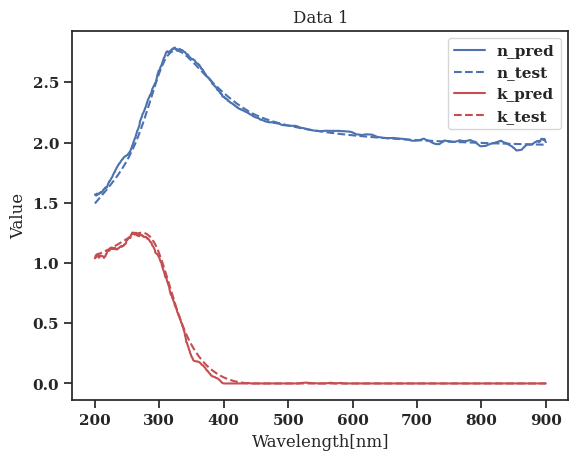

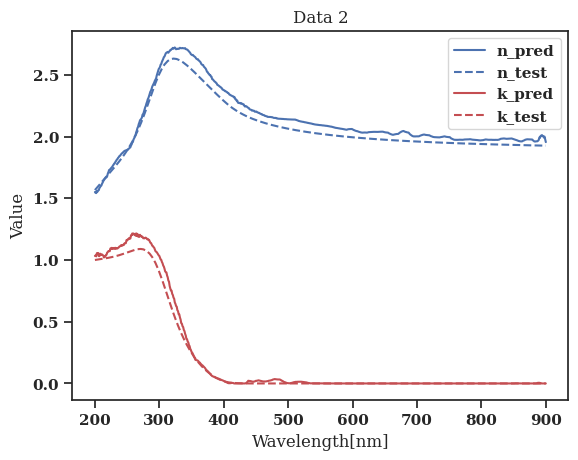

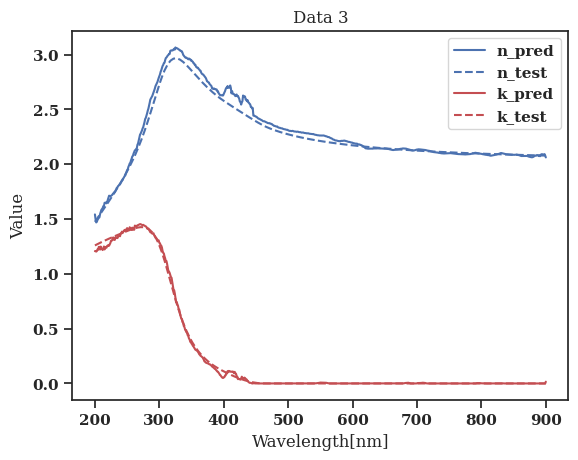

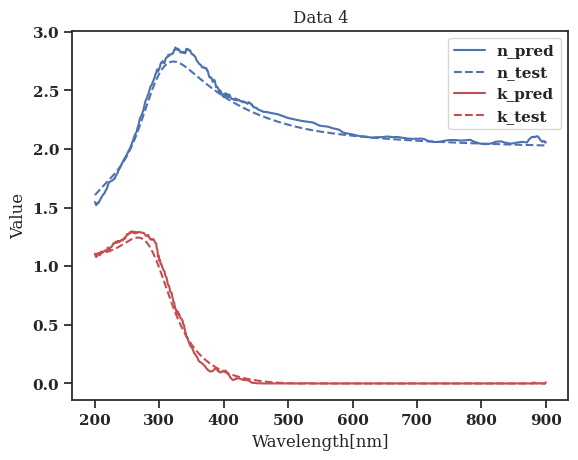

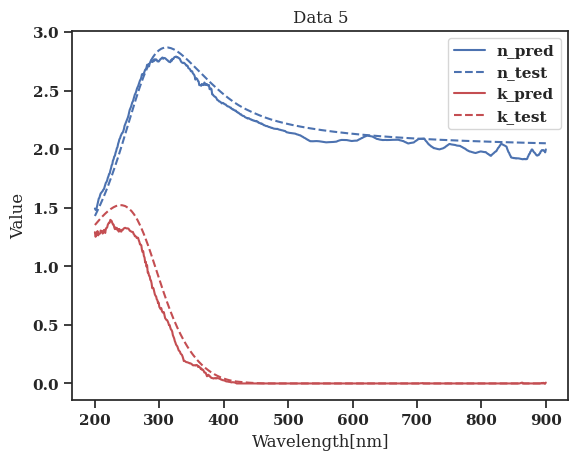

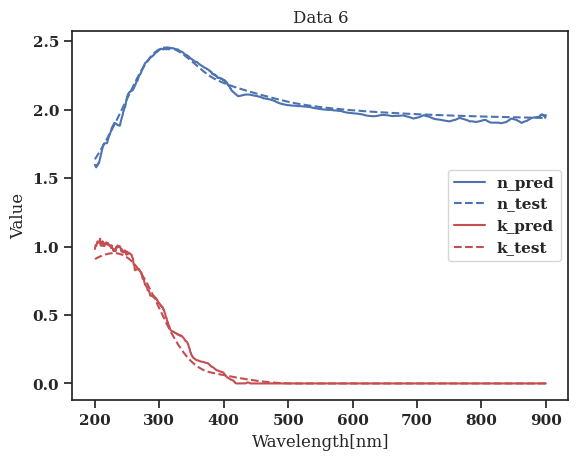

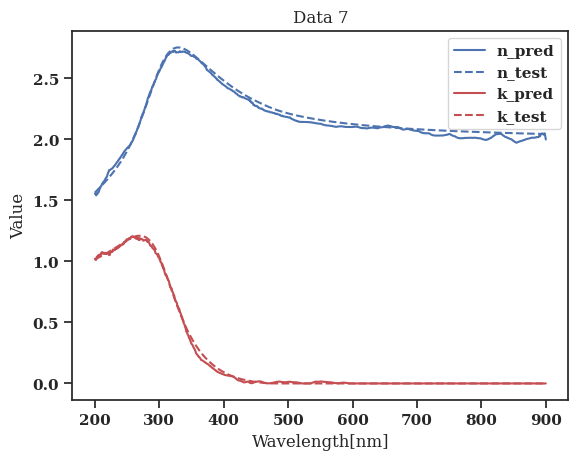

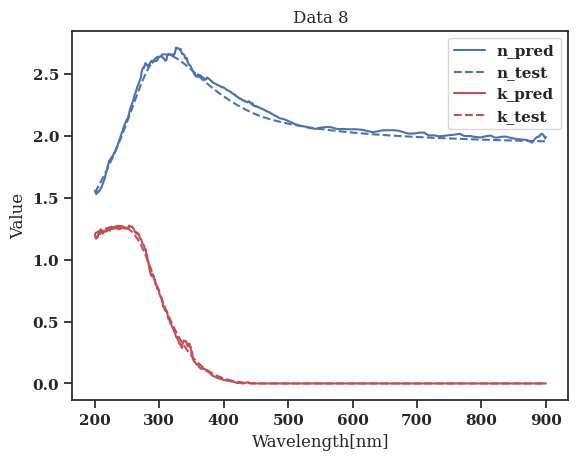

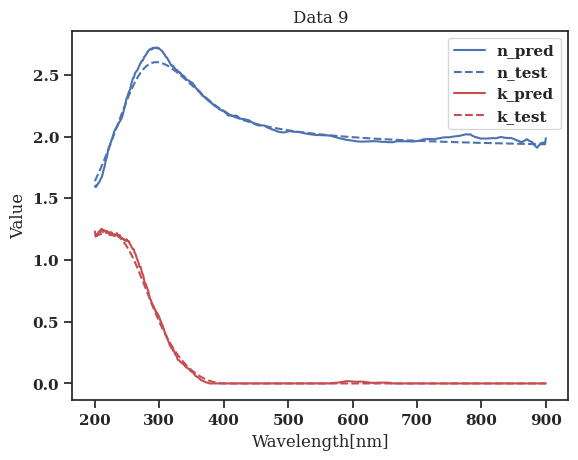

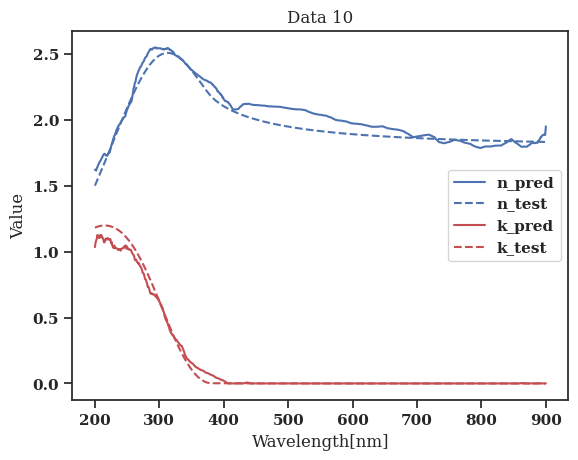

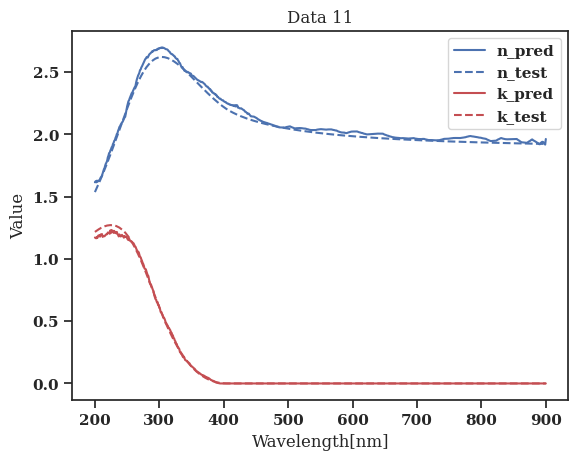

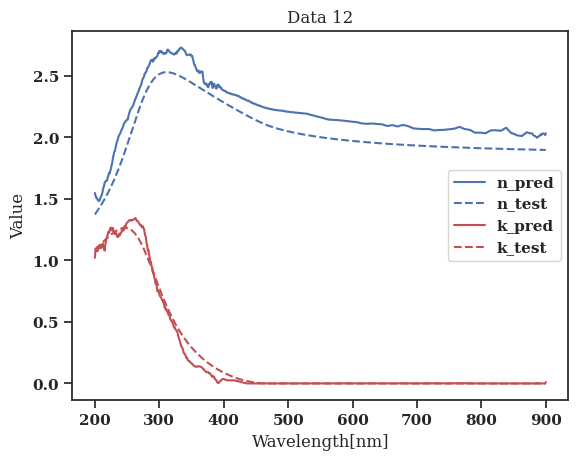

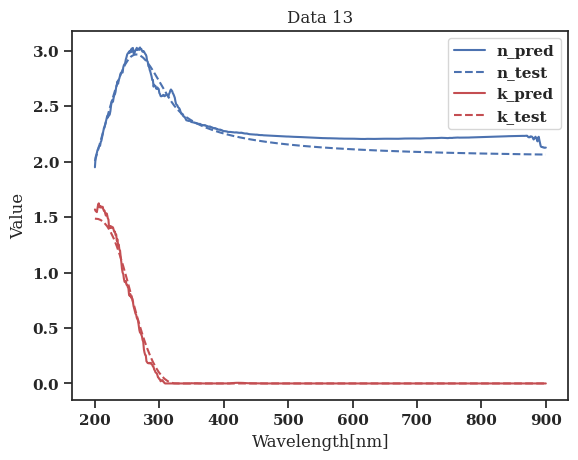

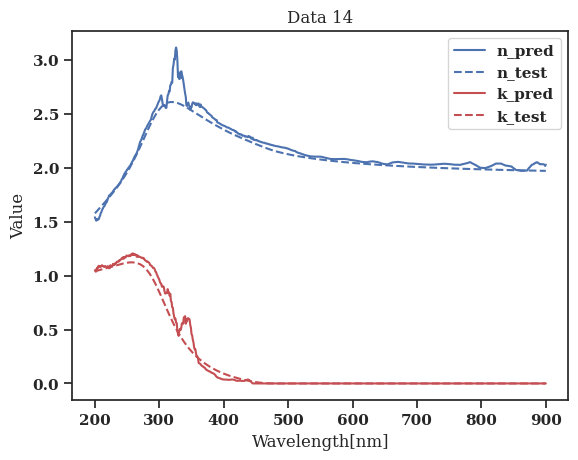

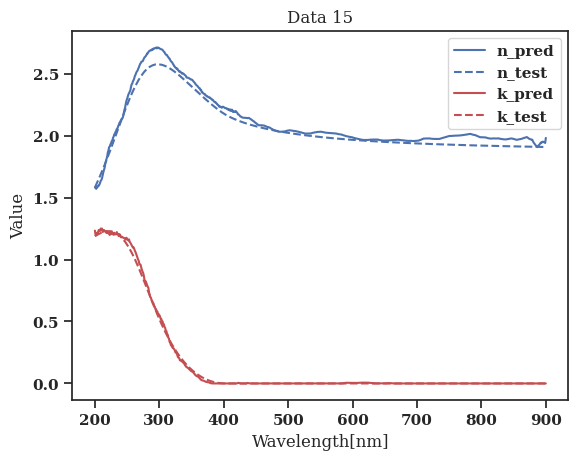

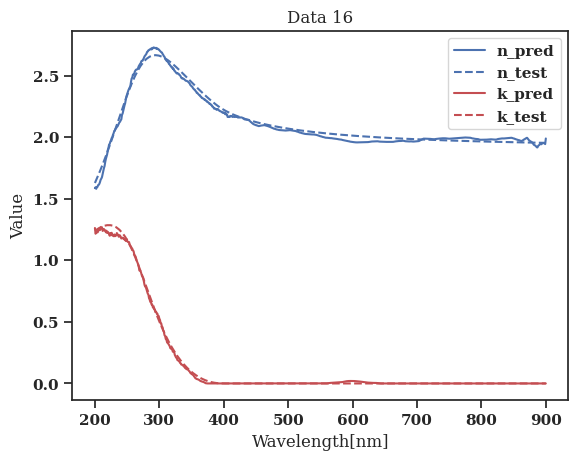

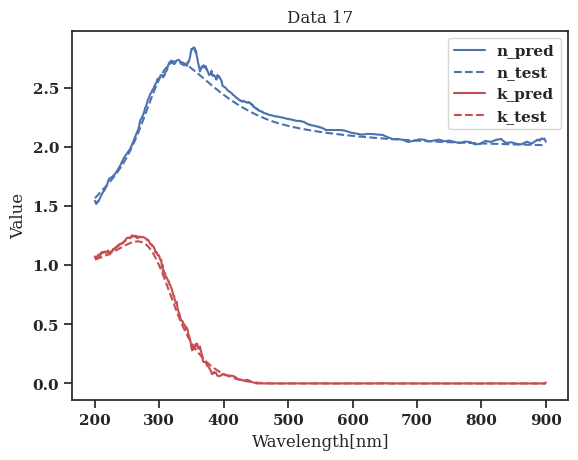

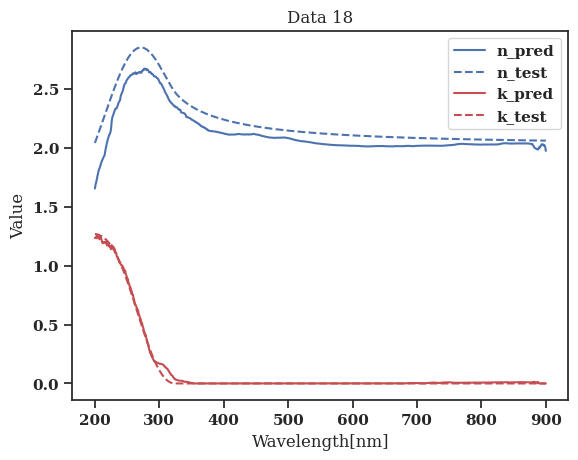

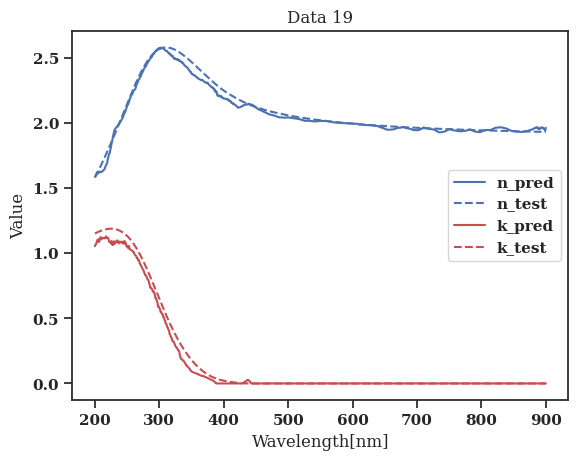

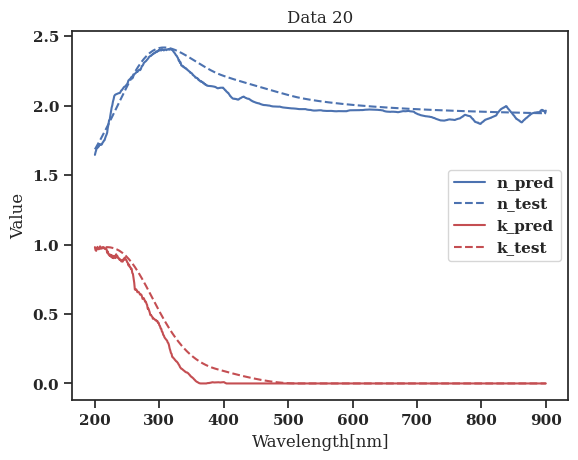

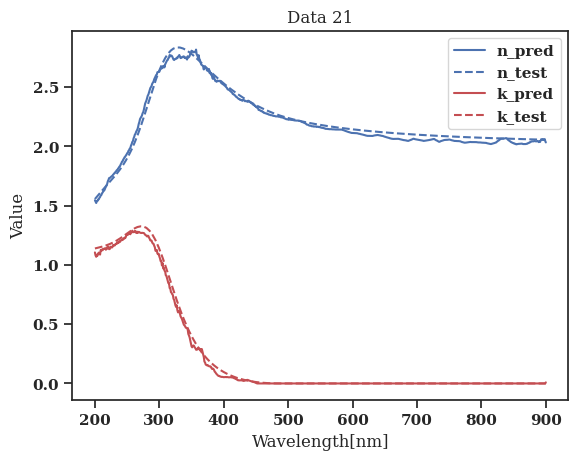

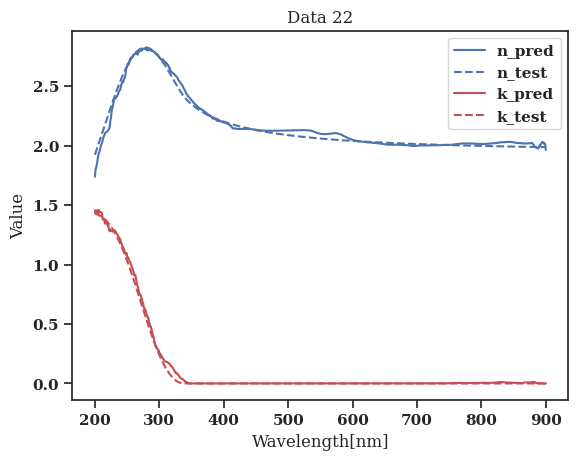

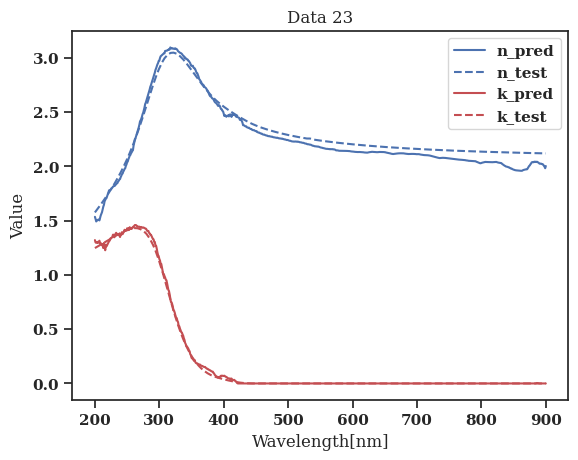

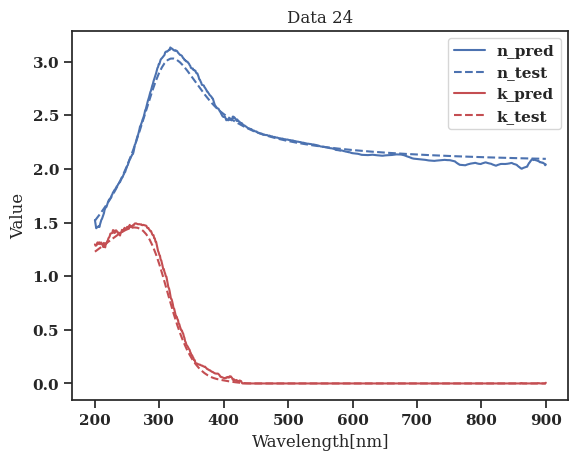

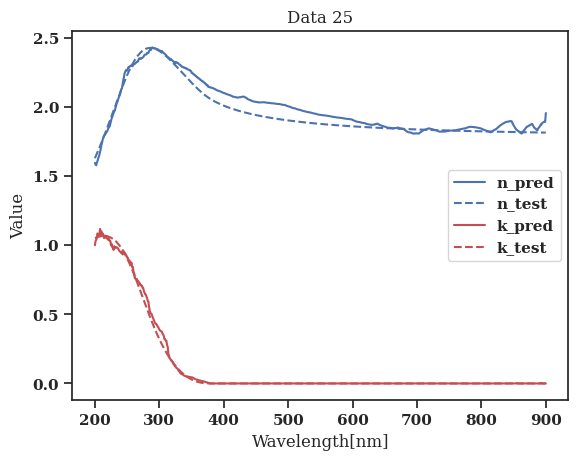

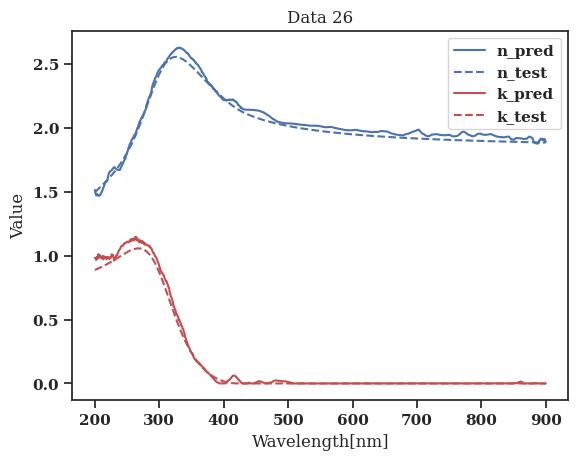

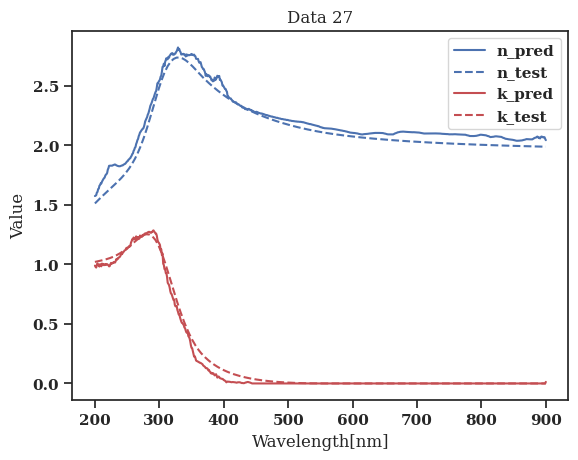

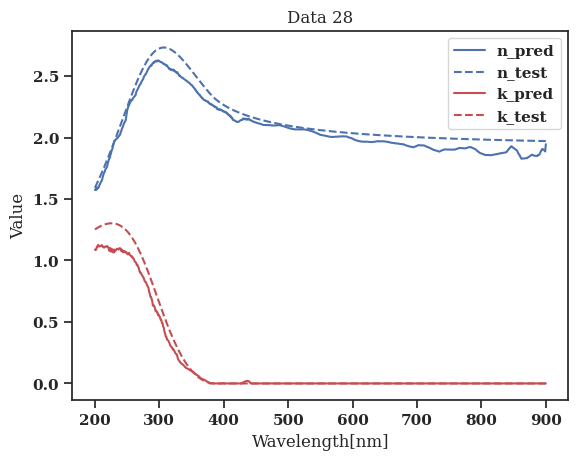

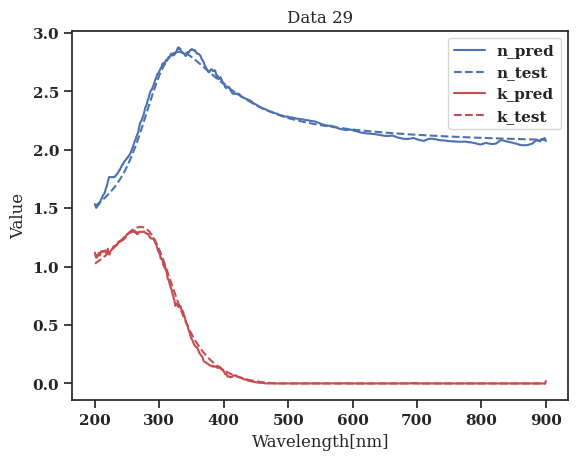

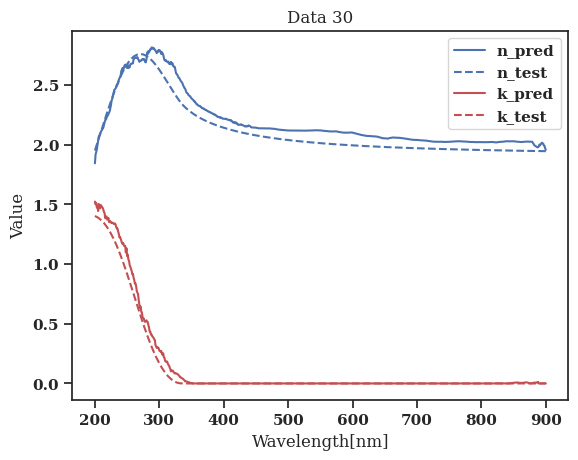

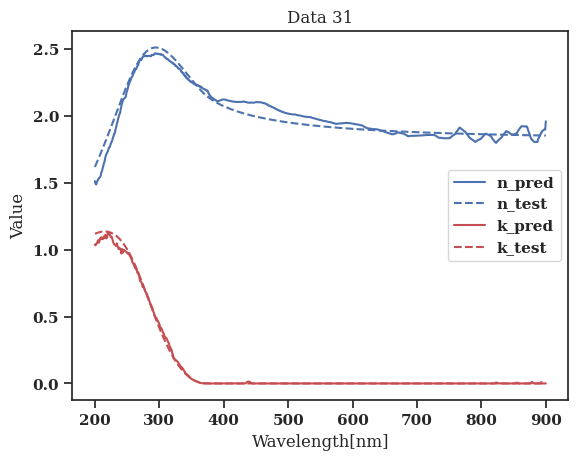

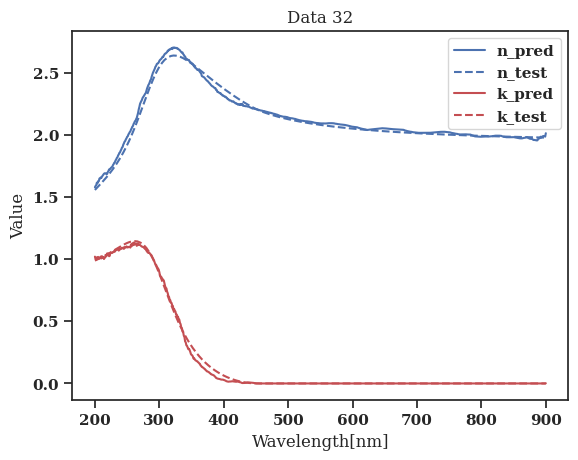

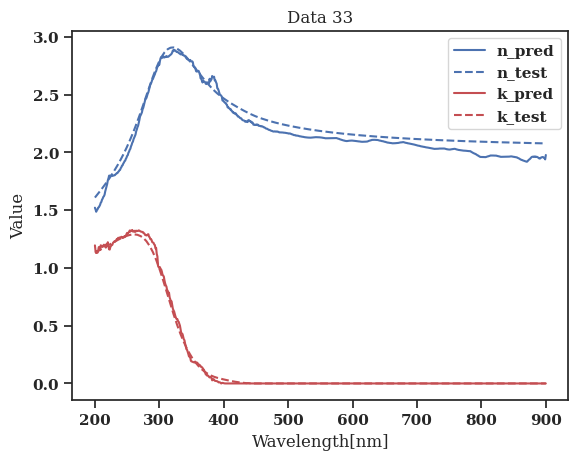

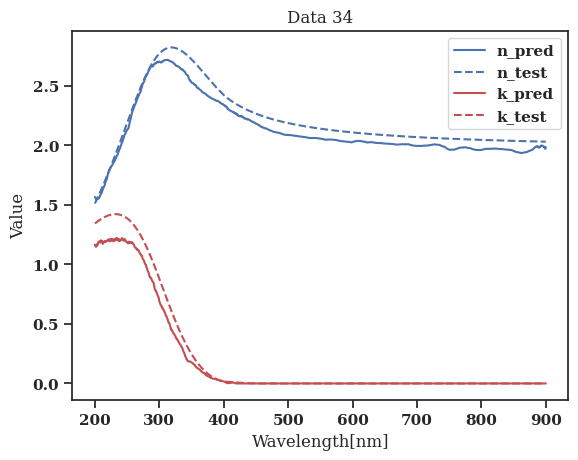

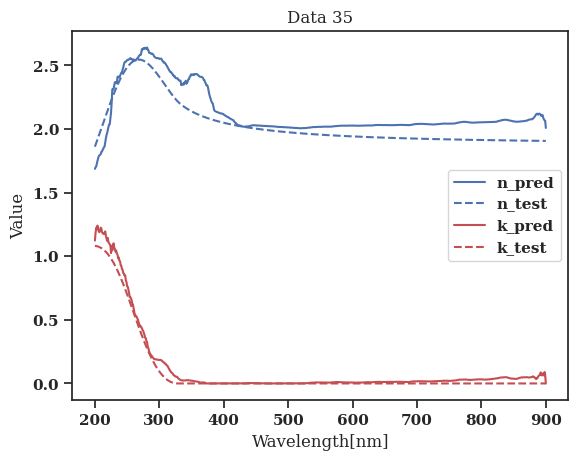

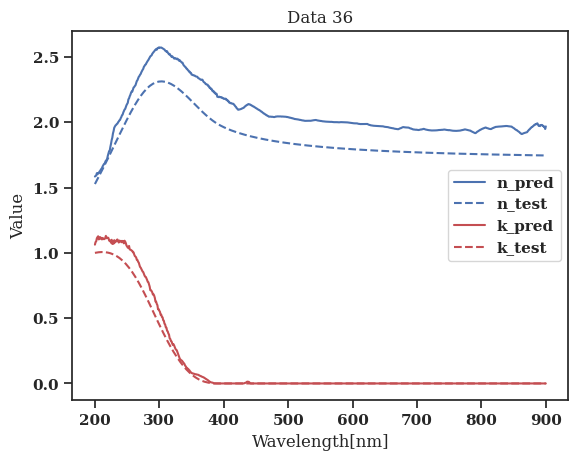

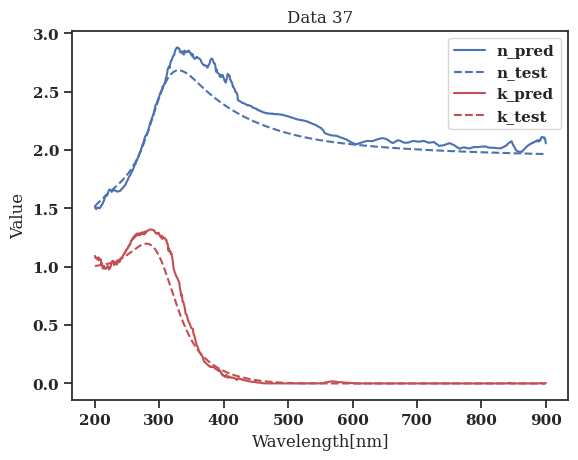

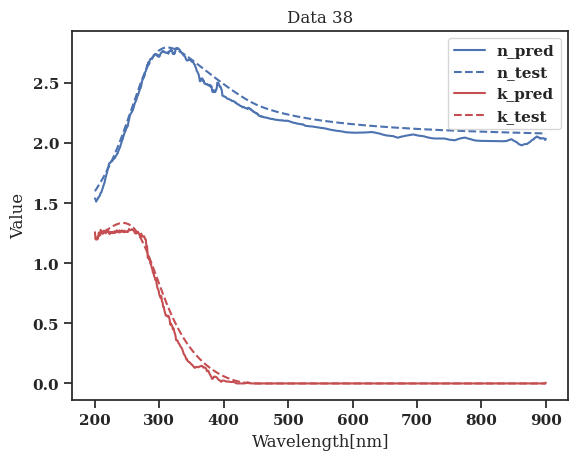

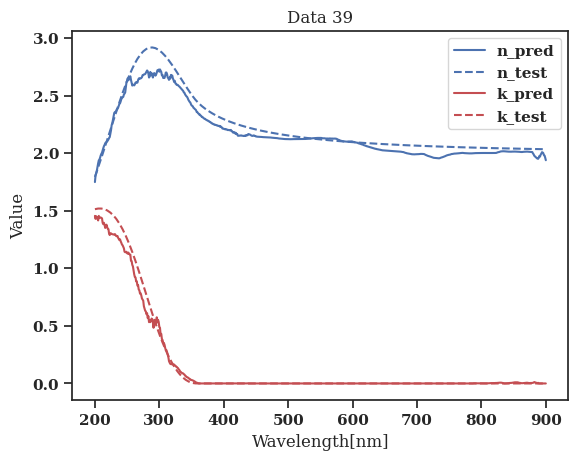

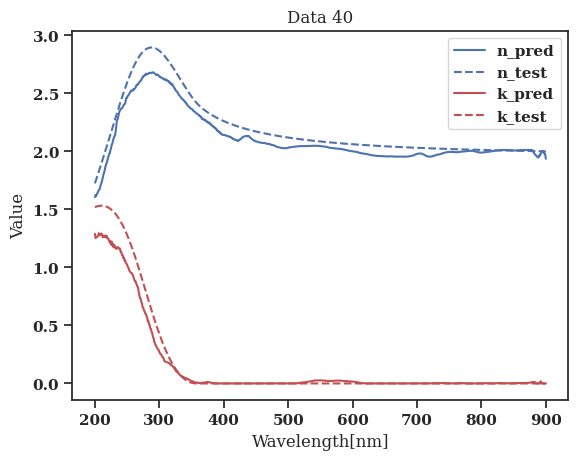

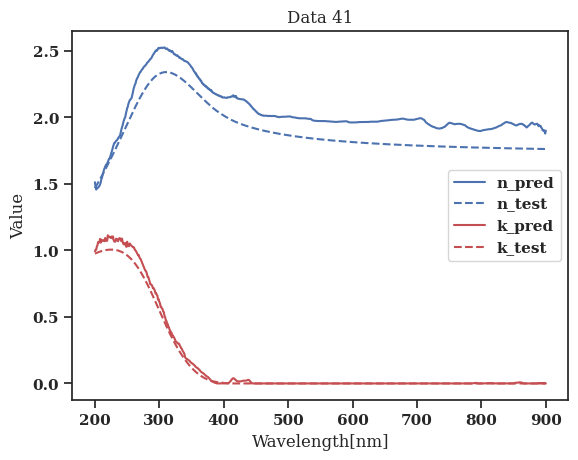

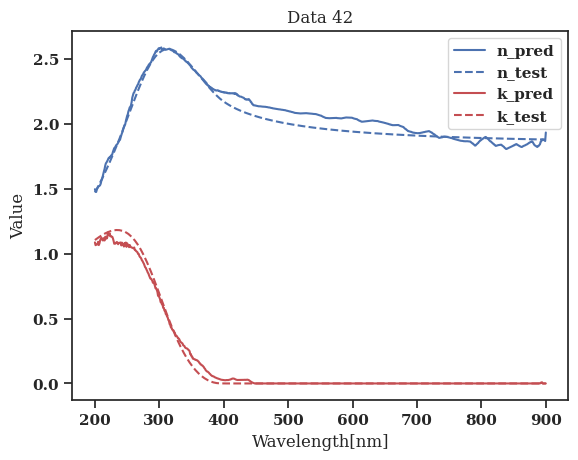

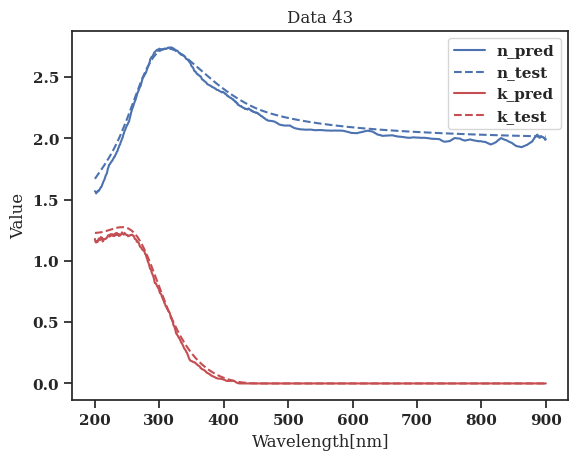

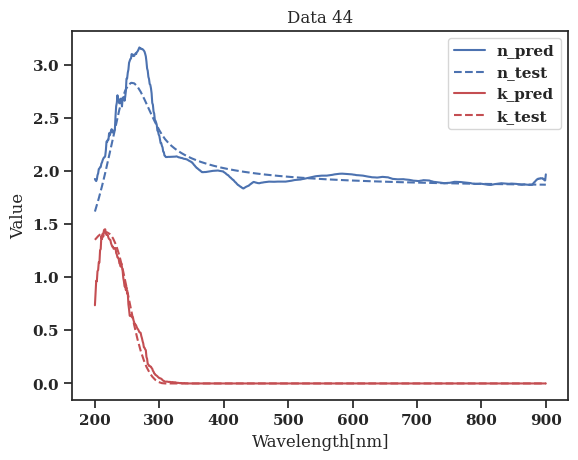

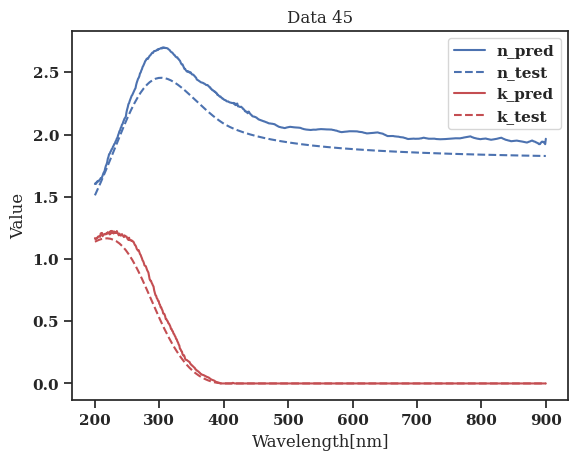

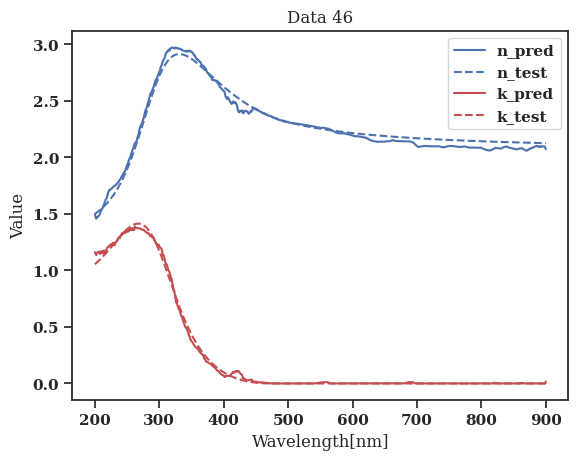

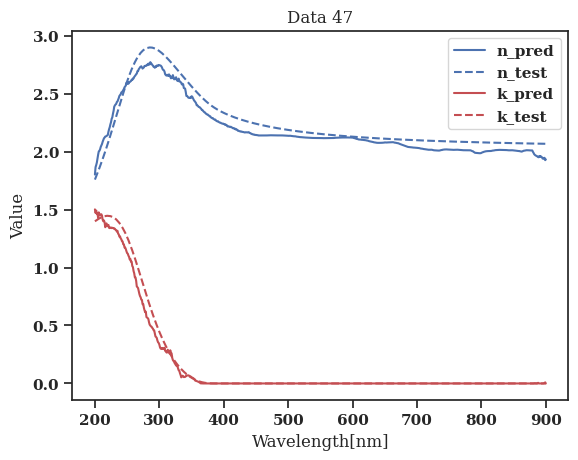

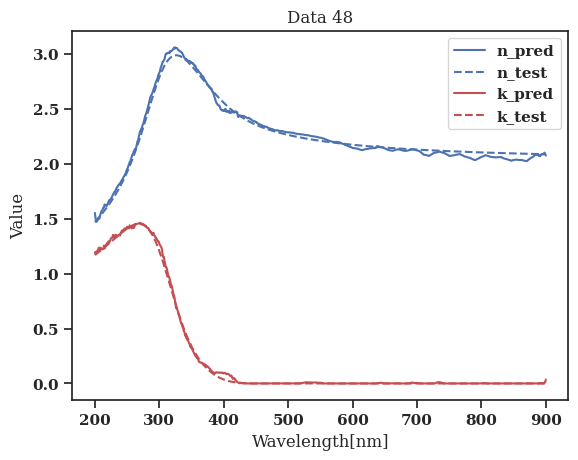

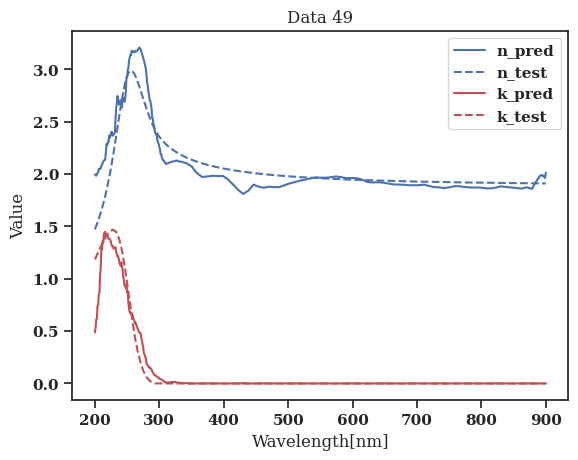

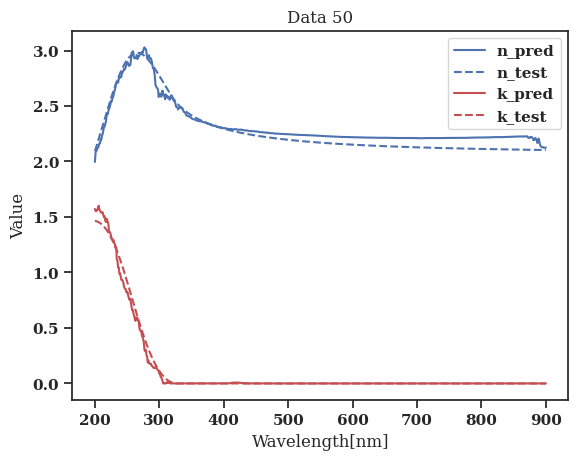

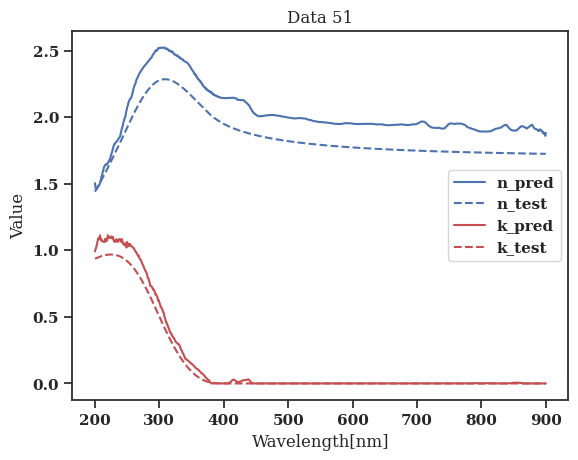

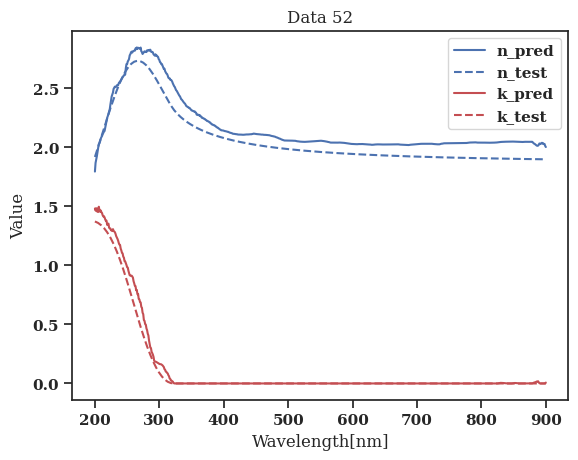

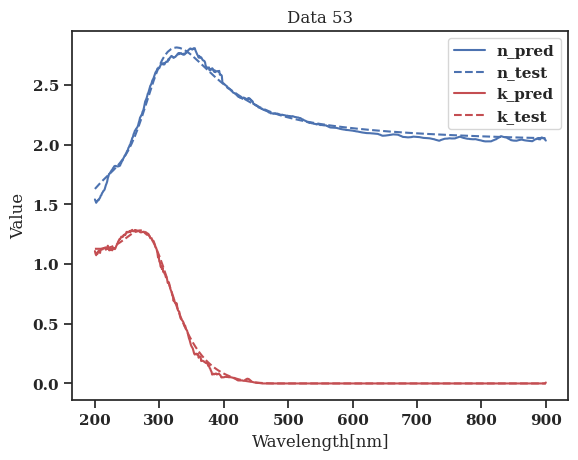

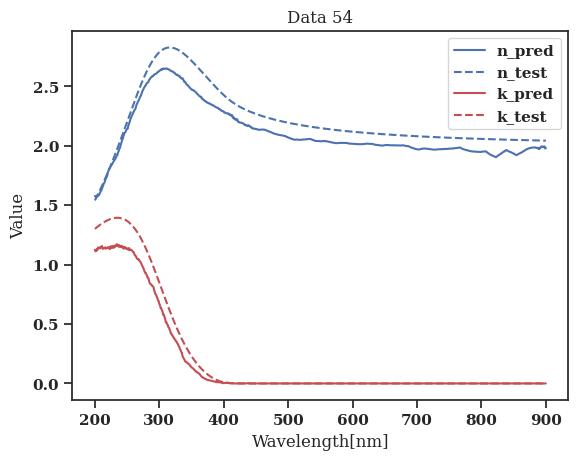

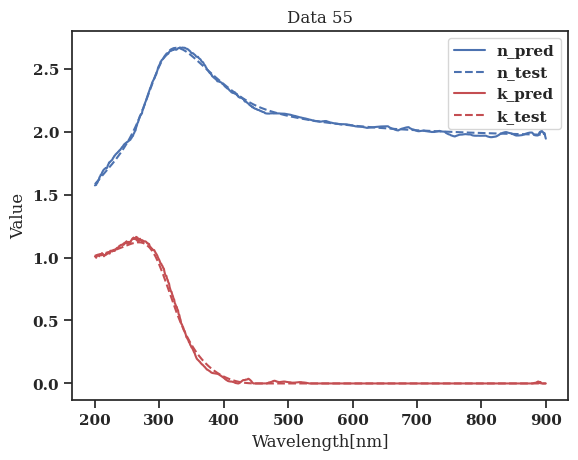

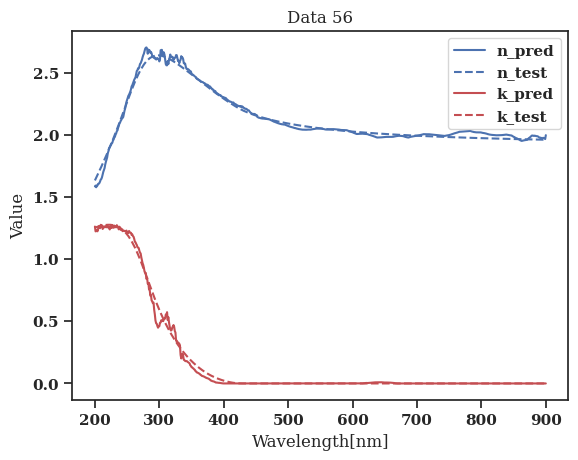

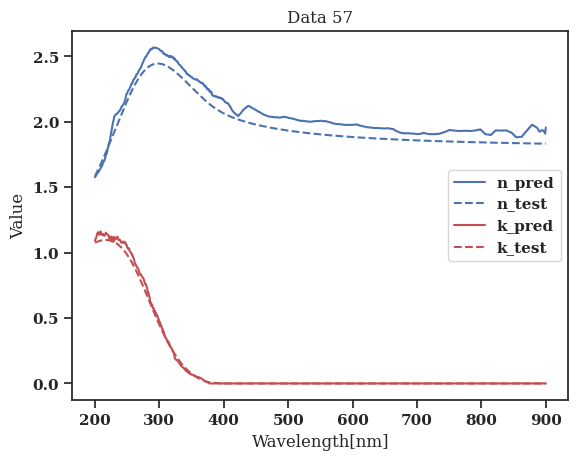

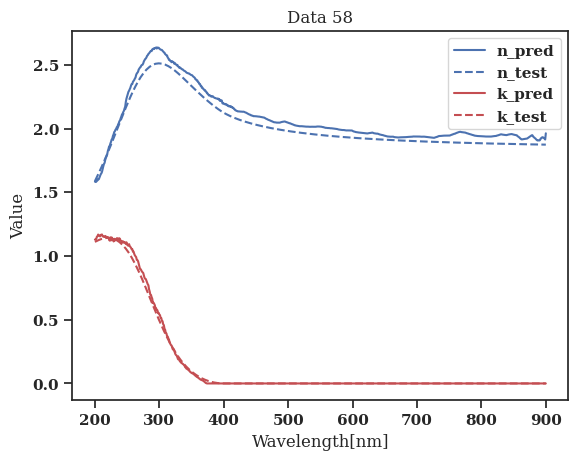

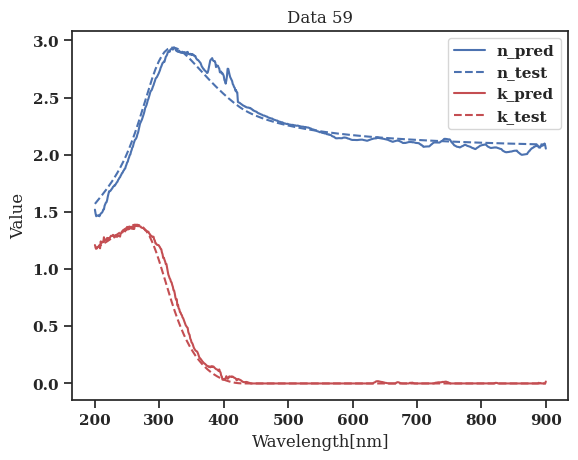

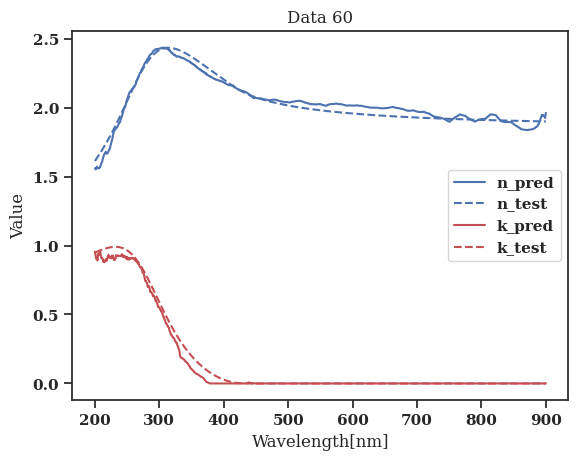

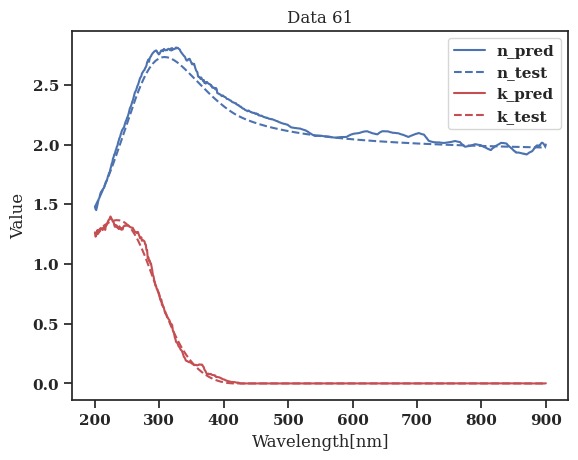

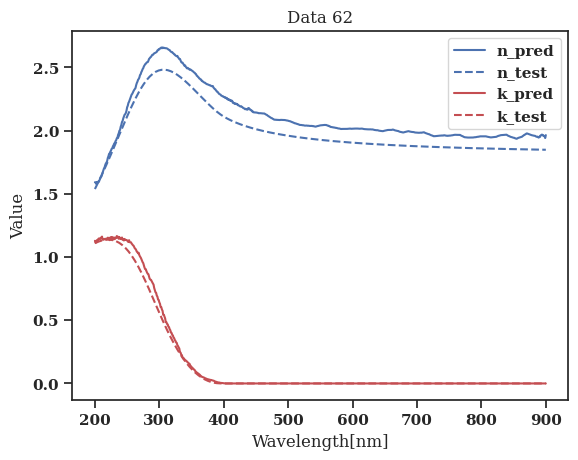

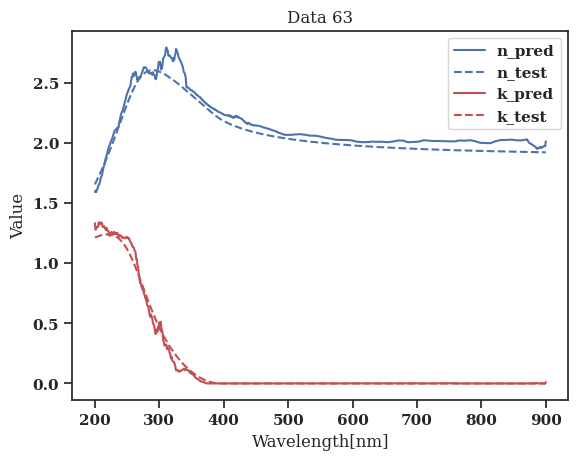

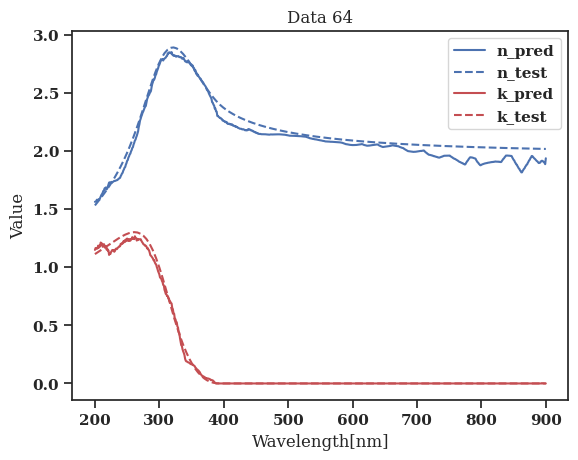

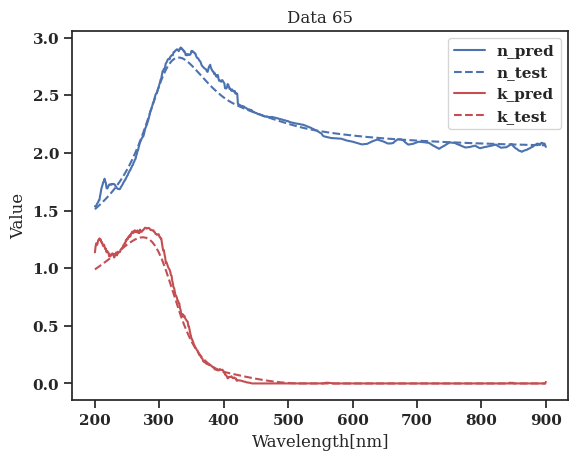

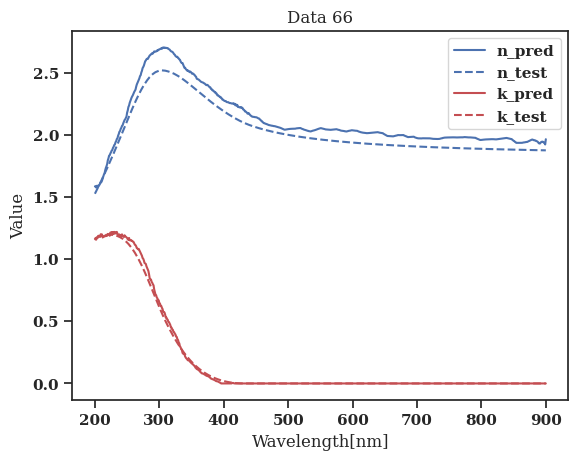

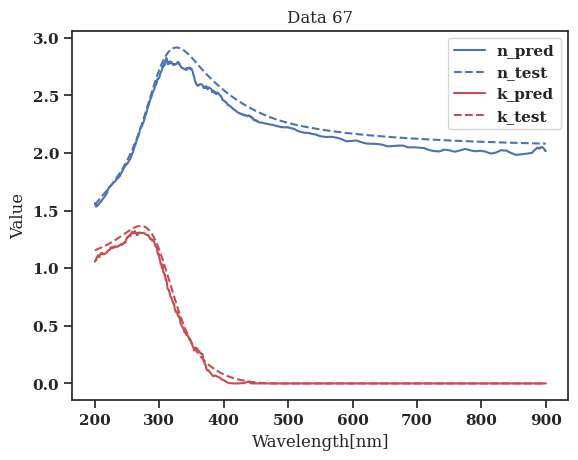

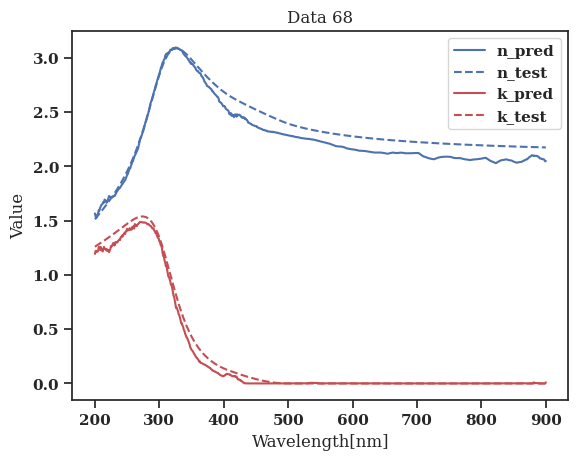

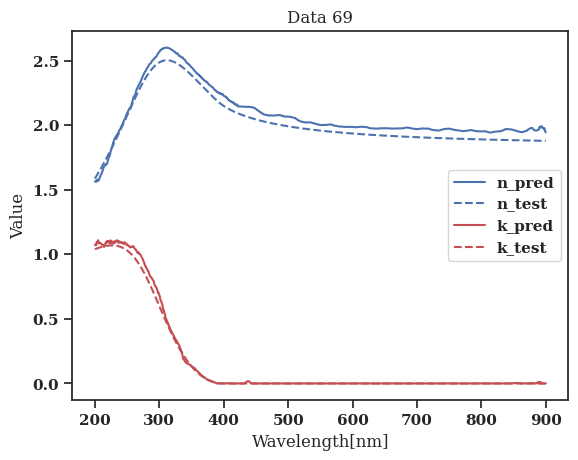

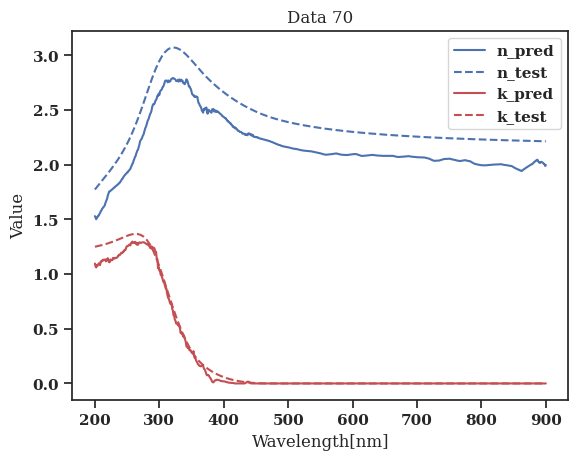

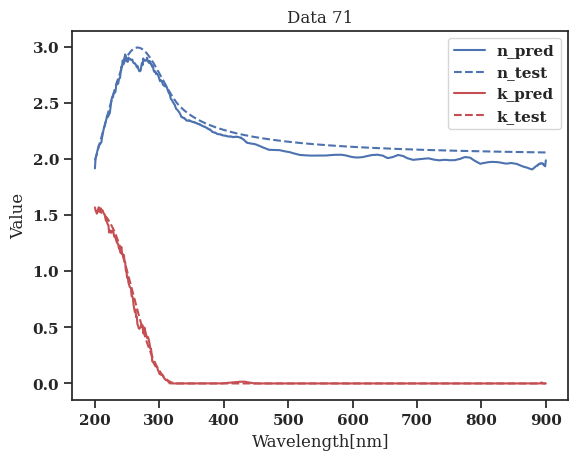

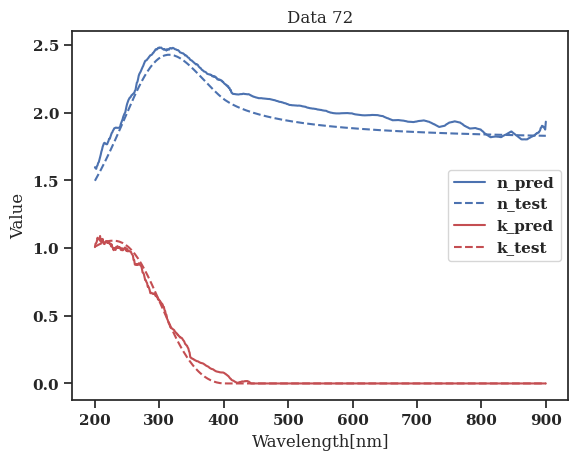

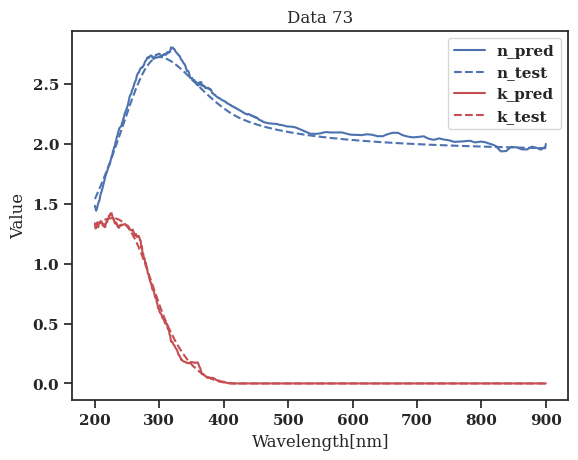

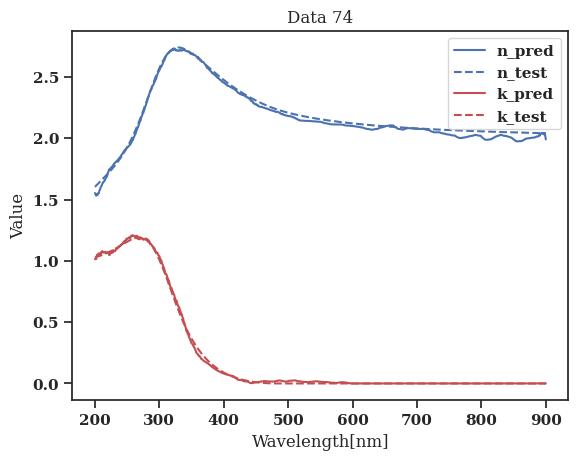

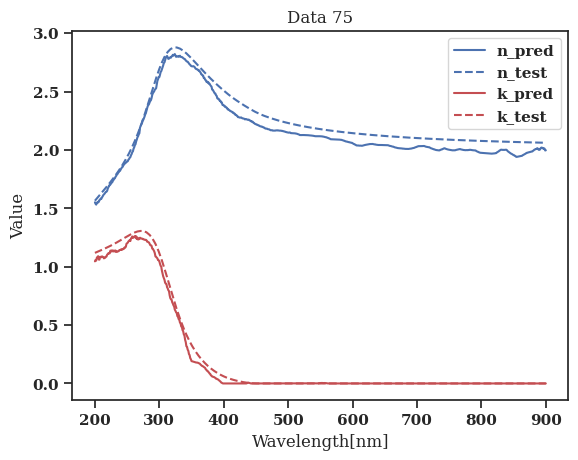

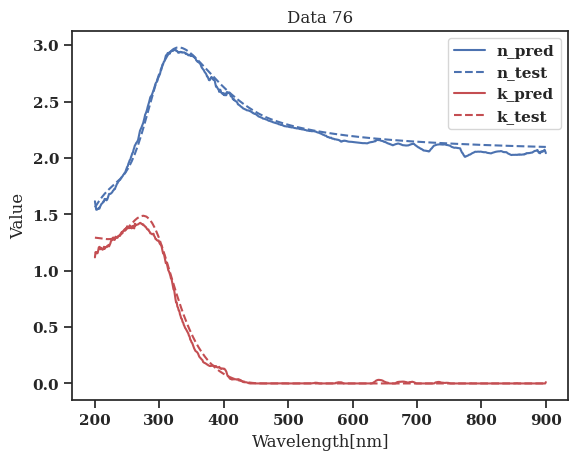

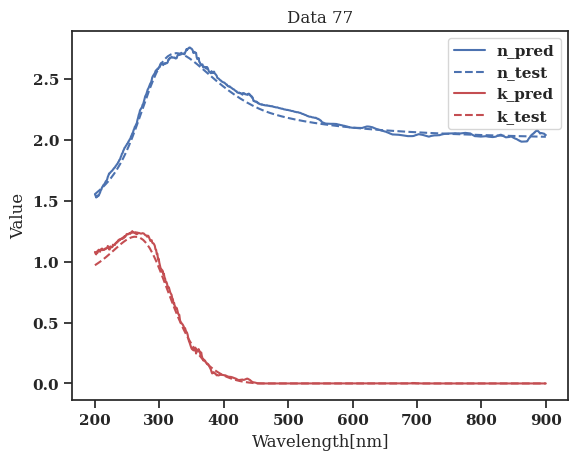

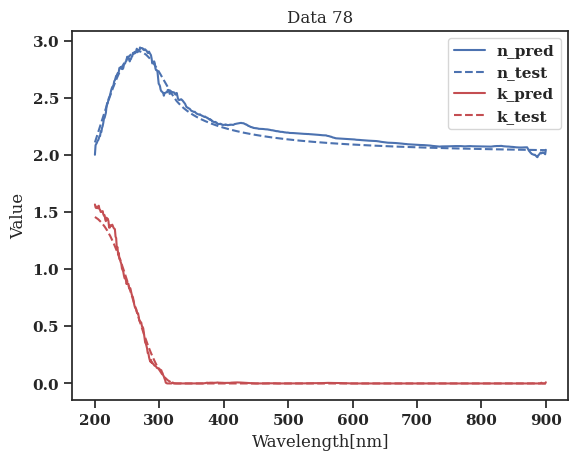

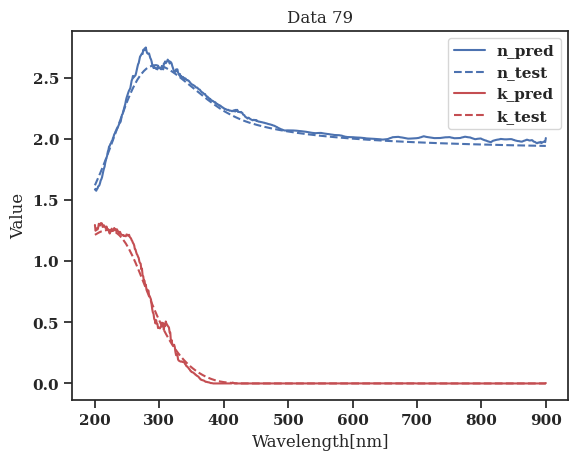

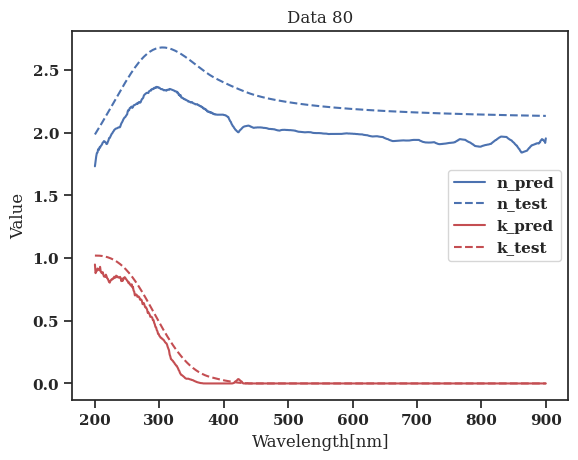

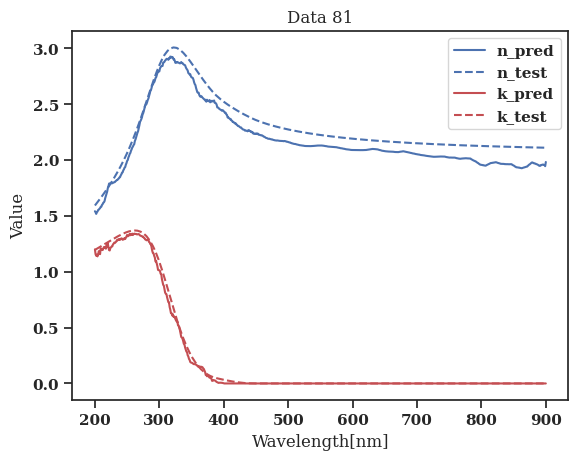

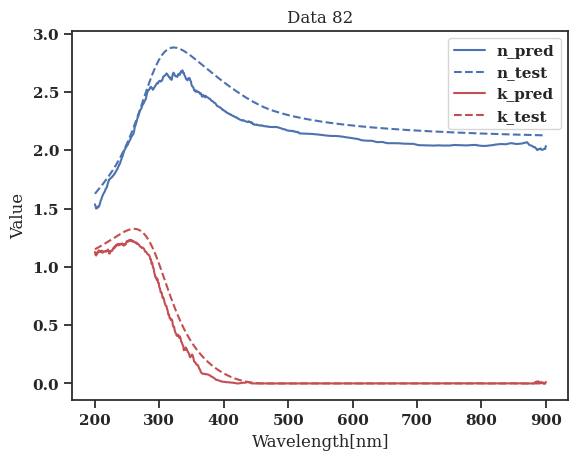

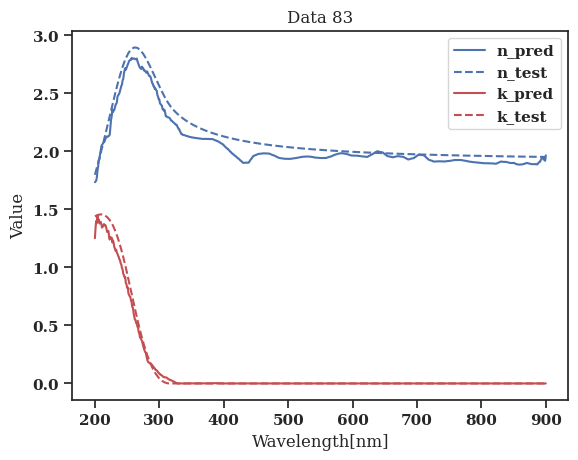

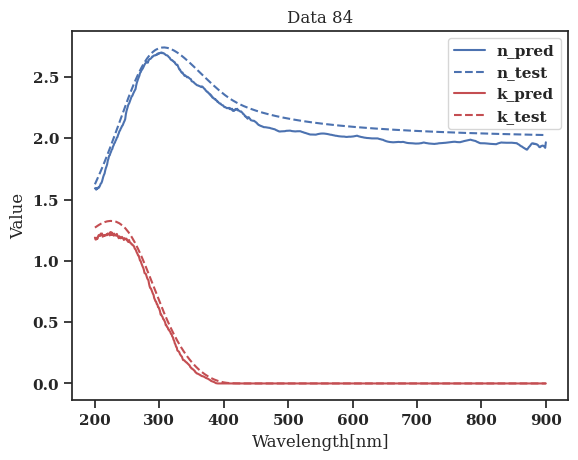

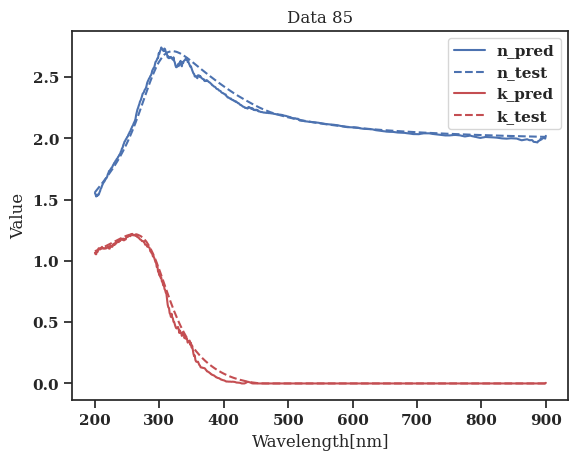

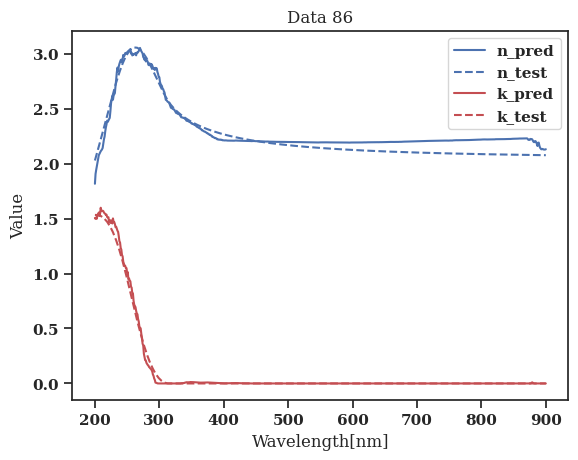

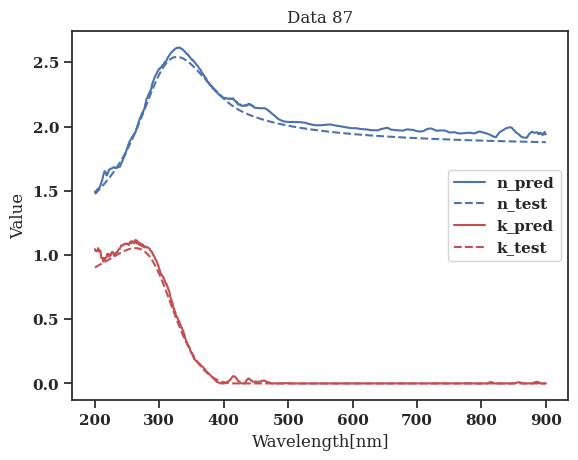

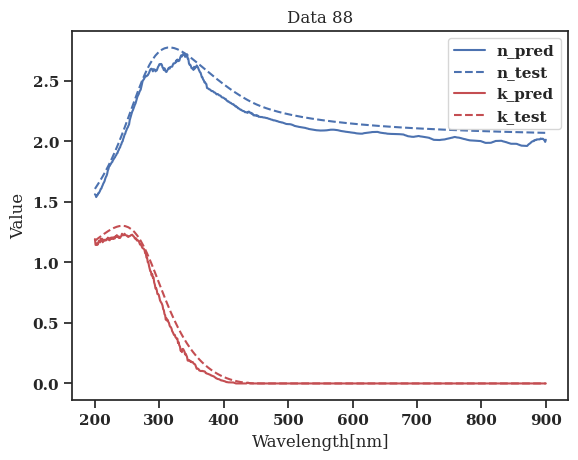

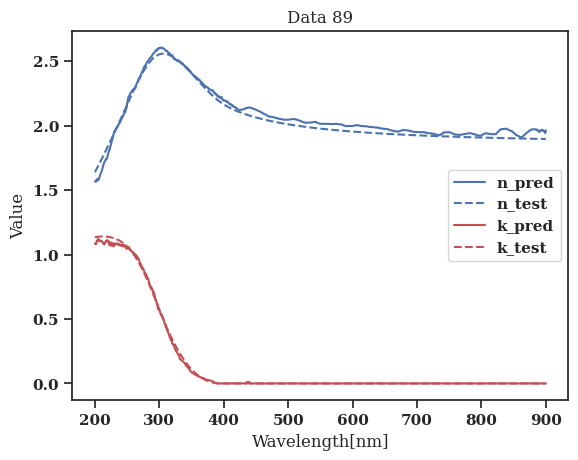

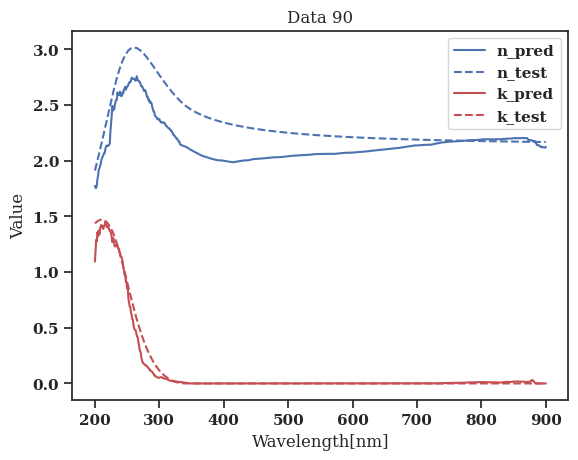

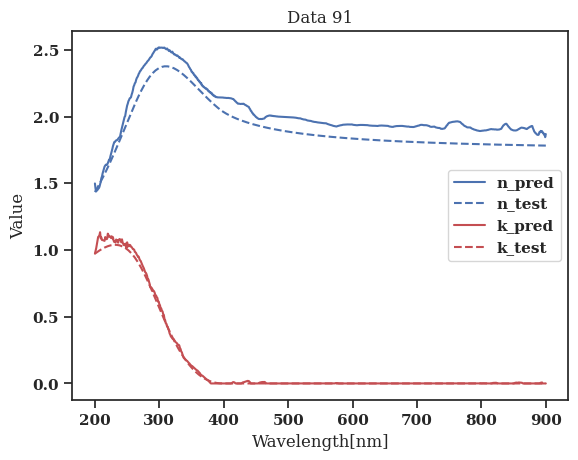

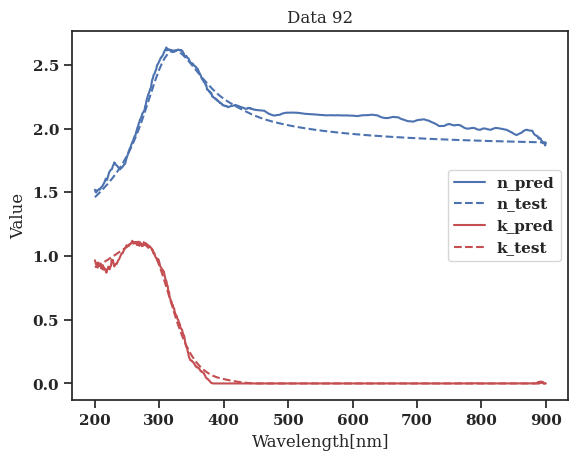

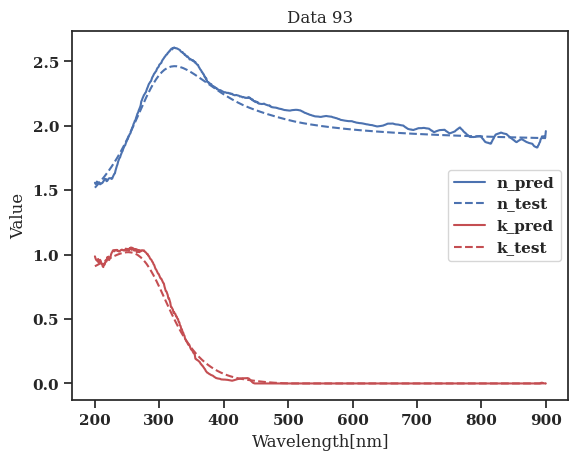

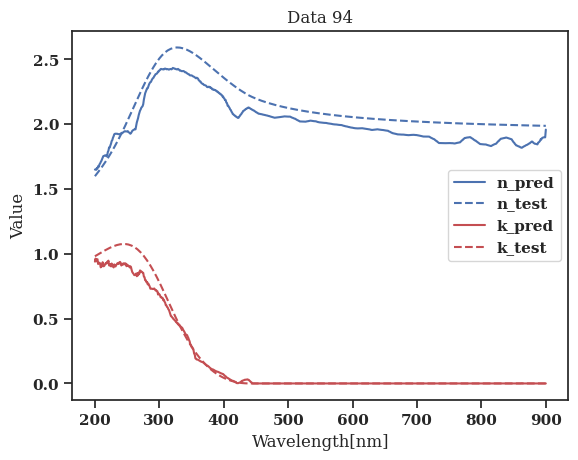

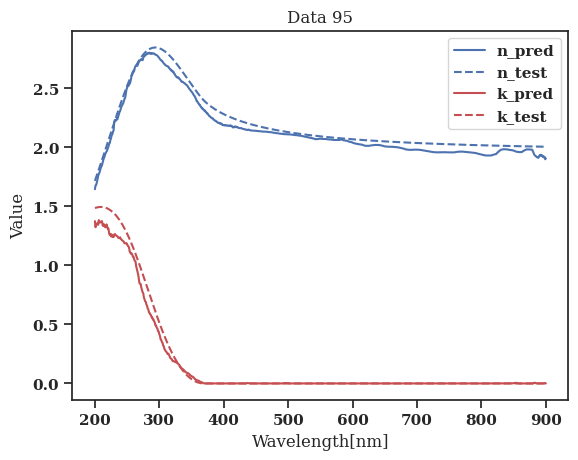

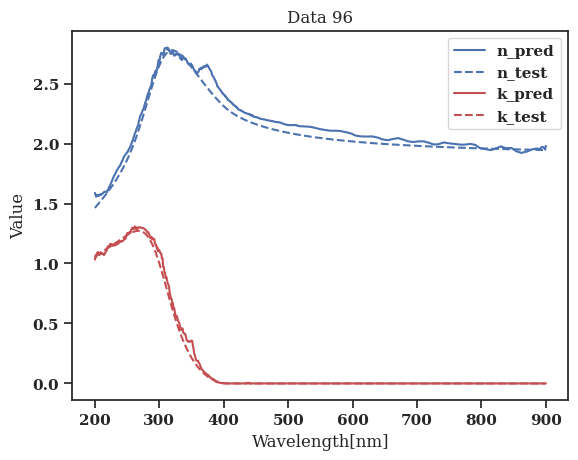

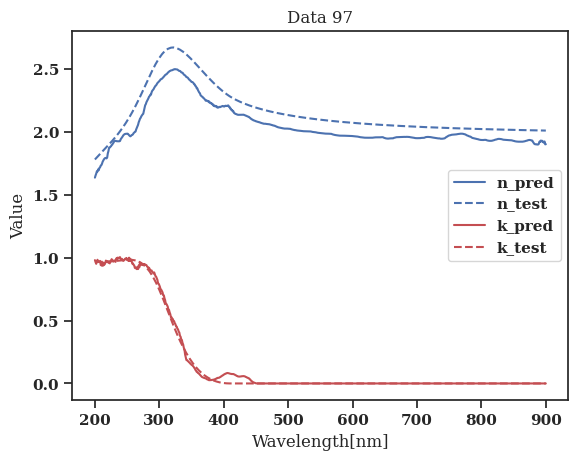

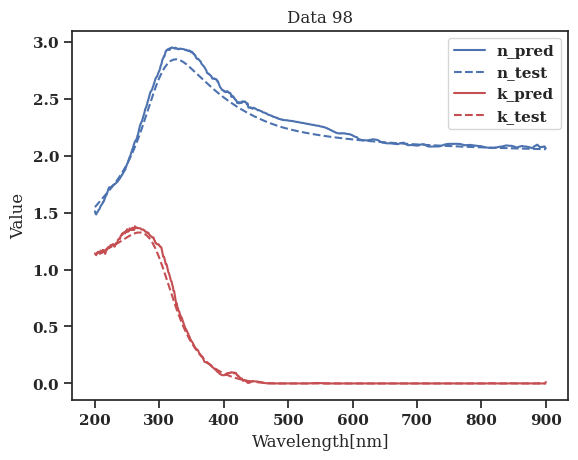

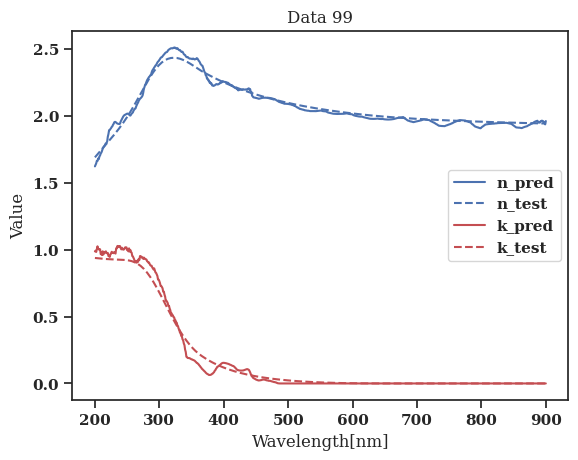

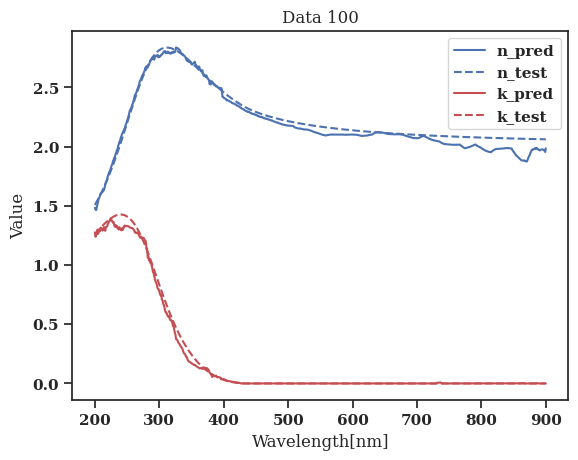

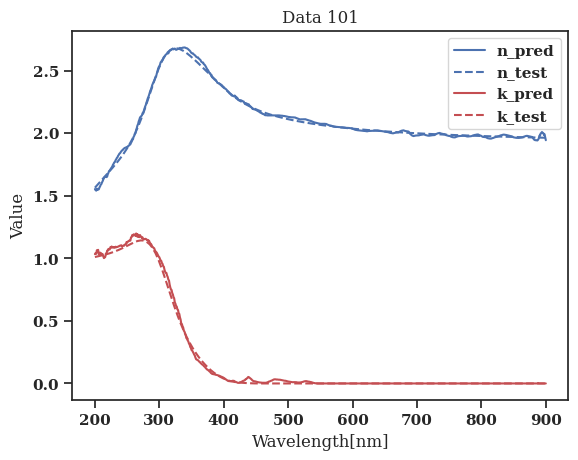

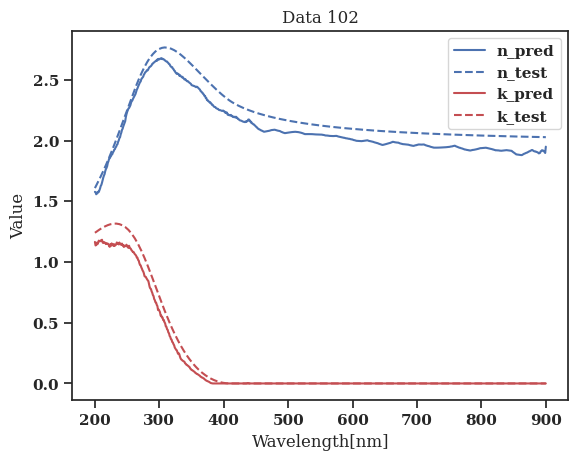

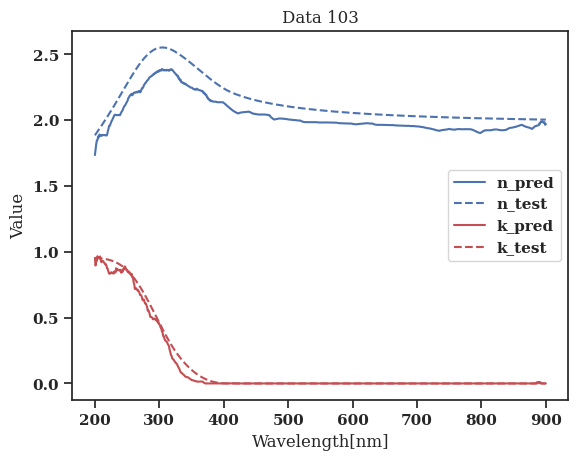

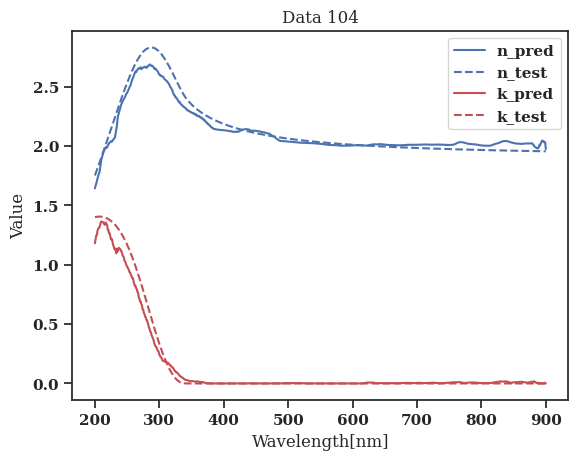

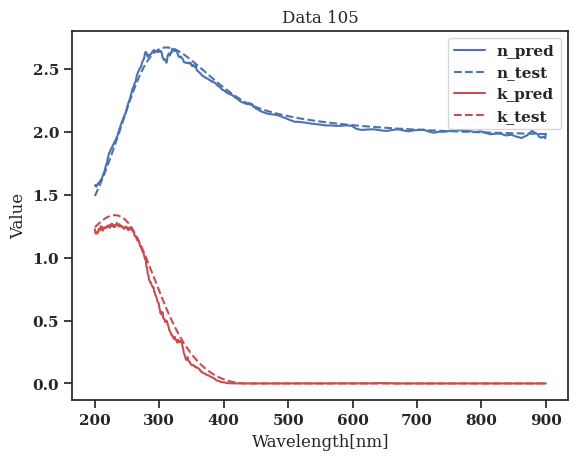

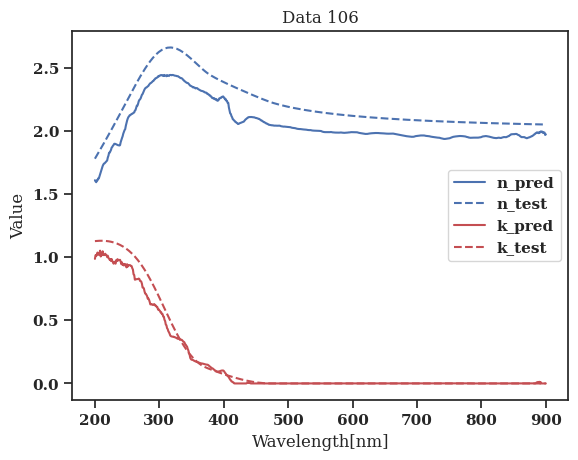

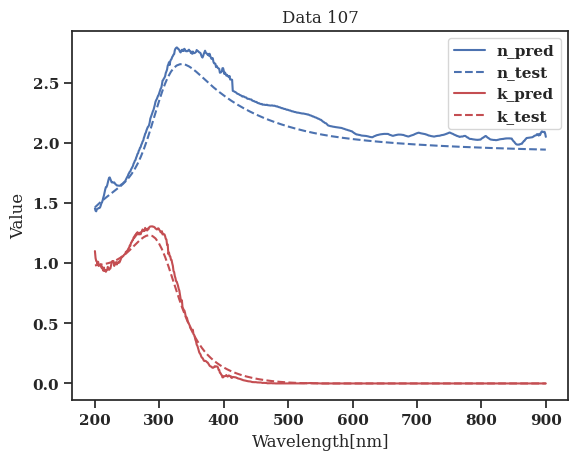

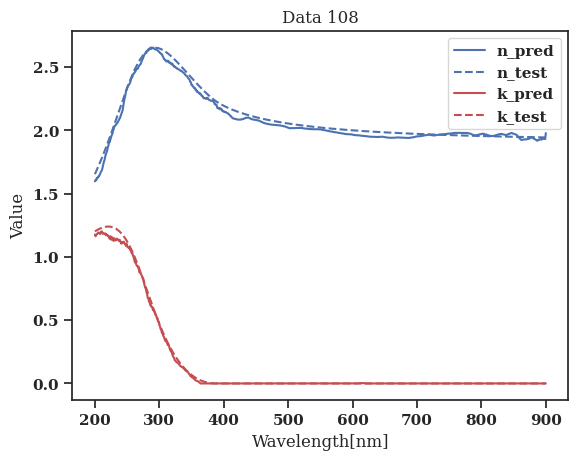

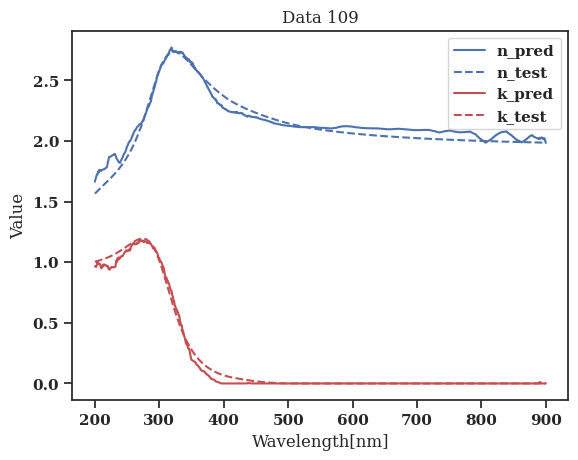

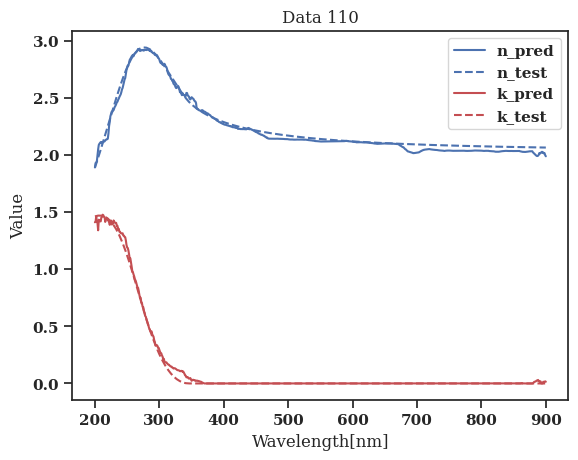

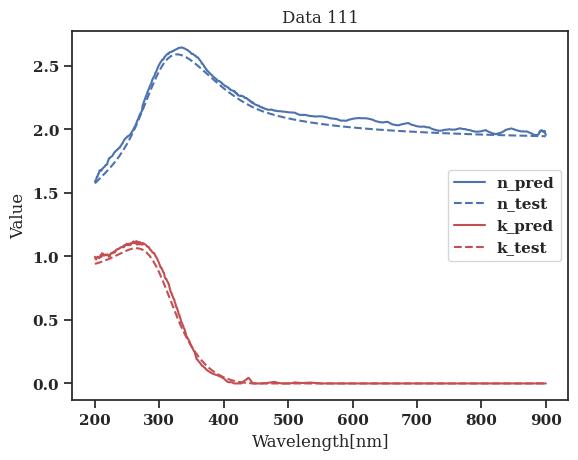

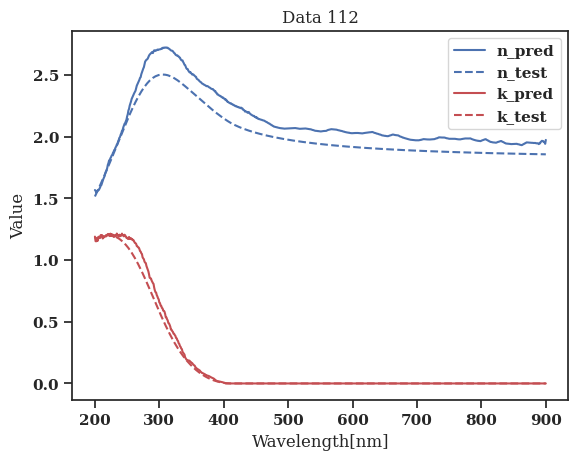

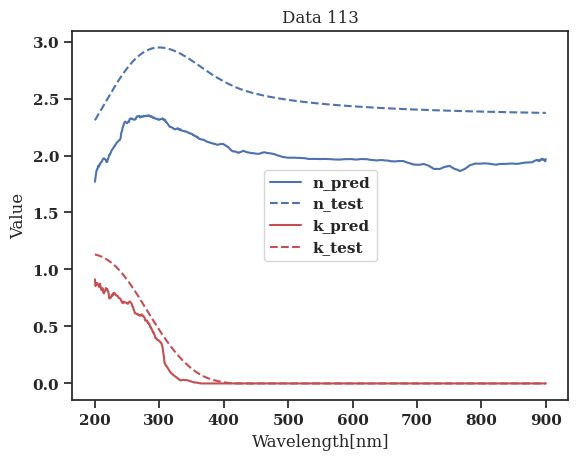

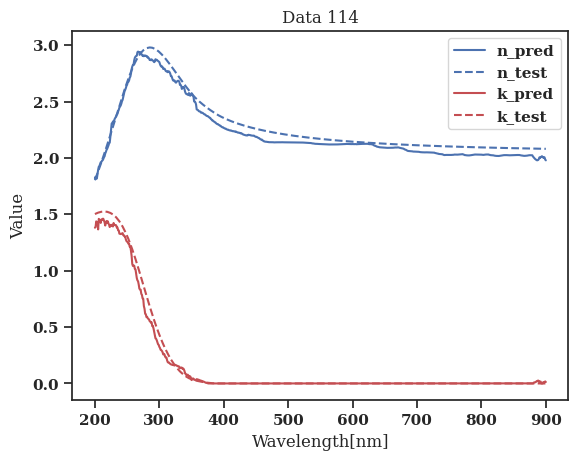

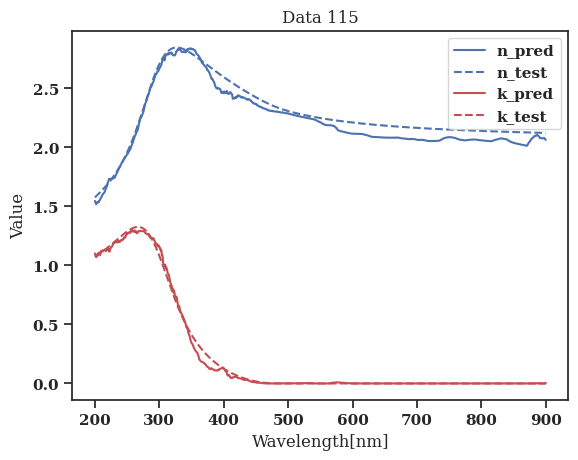

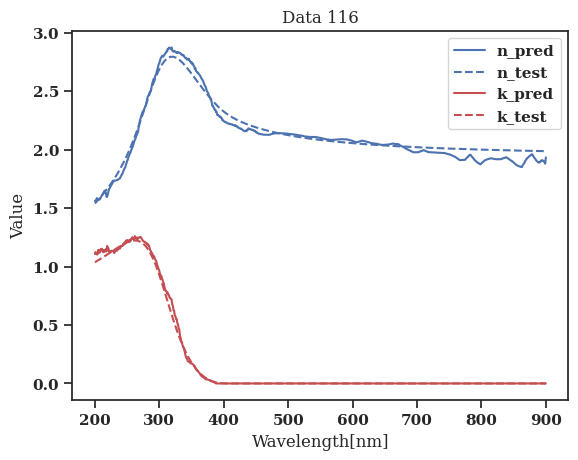

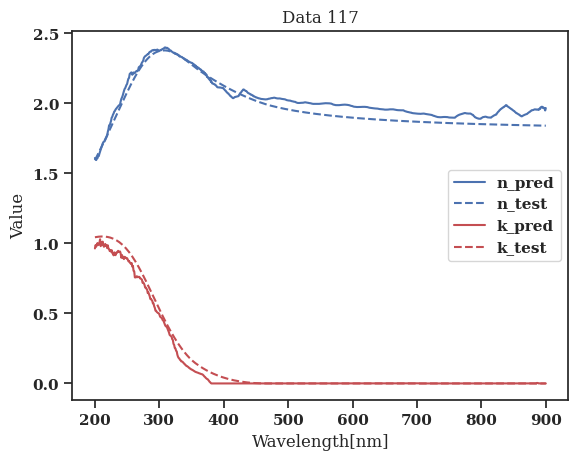

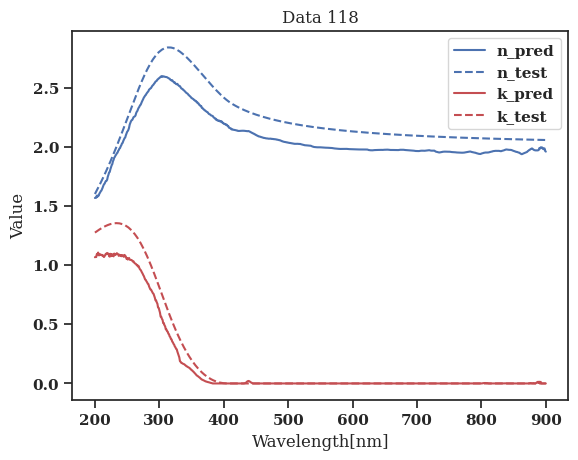

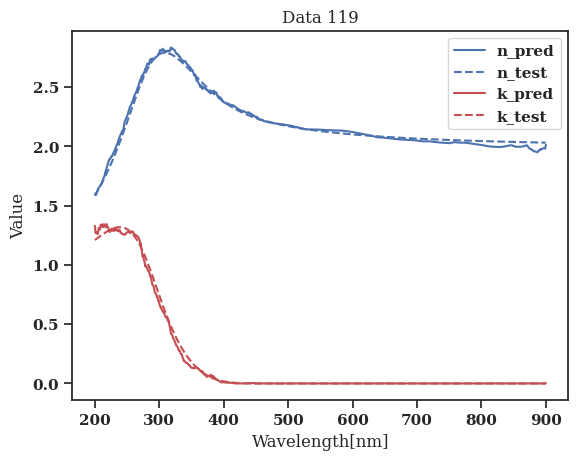

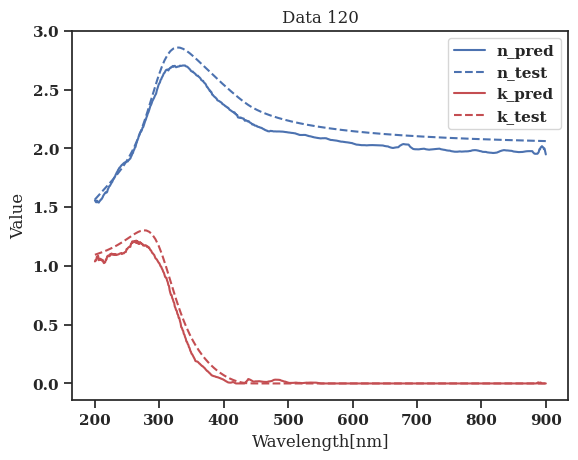

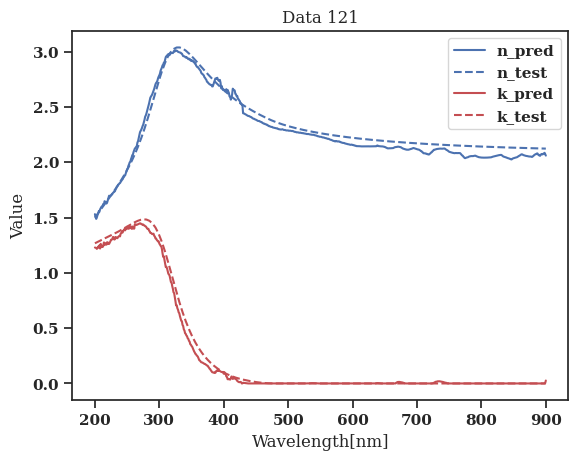

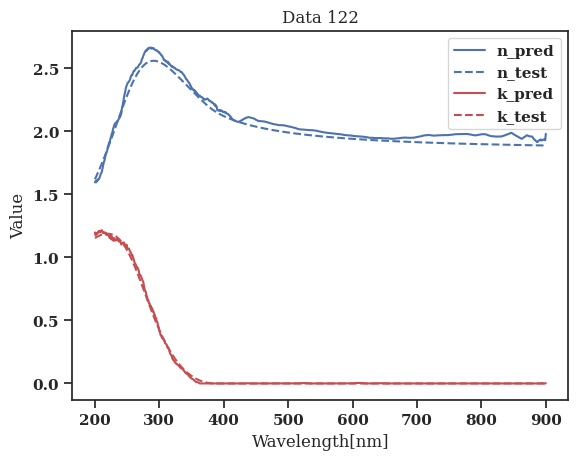

In [15]:
# Generate X-axis data
wavelength = range(200, 901)

# Go through 122 data and draw four curves
for i in range(122):
    plt.figure()
    plt.plot(wavelength, n_pred[i], 'b-', label='n_pred')
    plt.plot(wavelength, n_test[i], 'b--', label='n_test')
    plt.plot(wavelength, k_pred[i], 'r-', label='k_pred')
    plt.plot(wavelength, k_test[i], 'r--', label='k_test')
    
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Value')
    plt.title('Data {}'.format(i+1))
    plt.legend()
    plt.show()